# Imports

In [1]:
# import
import torch
import logging
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from utils.arg_extract import get_args
from utils.experiment_evaluator import evaluate_experiment
from utils.experiment import Experiment
from argparse import Namespace
from utils.experiment_evaluator import image_prepro, create_evaluation_dataloader, get_test_predictions_pairs, save_sequence_plots
import os
from utils.io import save
plt.ioff()
from utils.io import load
batch_images_all = load('batches.pickle')
import scipy as scp

import configparser
config = configparser.ConfigParser()
config.read('../config.ini')
# config['paths']['exp_folder']
        
data_directory = config['paths']['data_base']
experiments = [dI for dI in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, dI))]

# Model

In [2]:
exp = 'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7'

belated = False
dd = {'experiment_name': exp,
        'num_epochs': 1,
        'num_workers': 1,
        'test_starting_point': 15,
        'num_total_output_frames':80,
        'debug': False}

args_new = Namespace(**dd)
experiment = Experiment(args_new)
experiment.device='cpu'
experiment.load_from_disk(test=True)

# Viz latent space of ConvLSTM

In [3]:
import scipy.ndimage
model = experiment.model.cpu()
params = model.cpu().state_dict()

def show_kernels(param, lines, rows, interp='nearest', feature_map=0, deconv=False, zoom=3):
    p0 = params[param+'.weight']
    print(p0.size())
    fig, axarr = plt.subplots(lines, rows, figsize=(rows, lines))

    for i in range(lines):
        for k in range(rows):
            kk = i * rows + k
            if kk < p0.size(0 if deconv else 1):
                img = p0[kk, feature_map, :] if deconv else p0[feature_map, kk, :] 
                img = scp.ndimage.zoom(img, zoom=zoom)
                axarr[i, k].imshow(img, cmap='gray', interpolation=interp, vmin=p0.min(), vmax=p0.max())
            axarr[i, k].set_yticks([])
            axarr[i, k].set_xticks([])
    plt.show()

In [4]:
def mean_activation_histogram(param, deconv=False):
    p0 = params[param+'.weight']
    p0b = params[param+'.bias']
    dim = (0,2,3) if deconv else (1,2,3)
    pp = p0.mean(dim) + p0b
    plt.hist(pp)
    plt.show()

## First layer kernels

In [5]:
model

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

torch.Size([64, 5, 3, 3])


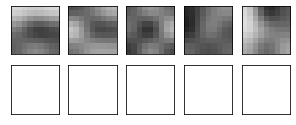

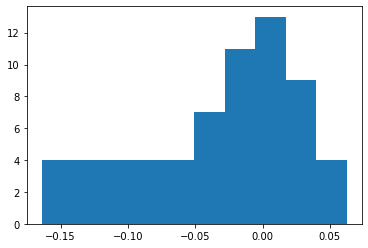

In [6]:
# Conv 1.0
lines = 2
rows = 5
feature_map = 0

param = 'dconv_down1.0'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map, zoom=3)
mean_activation_histogram(param)

torch.Size([64, 64, 3, 3])


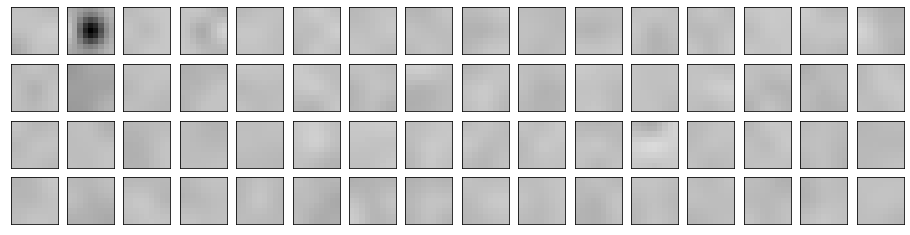

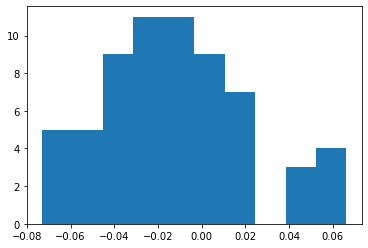

In [7]:
# conv 1.2 
lines = 4
rows = 16

feature_map = 0

param = 'dconv_down1.2'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map)
mean_activation_histogram(param)

torch.Size([128, 64, 3, 3])


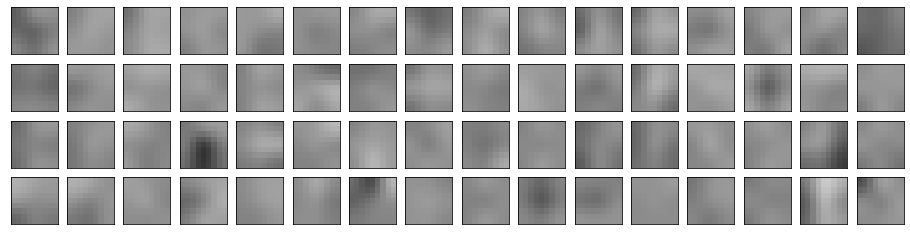

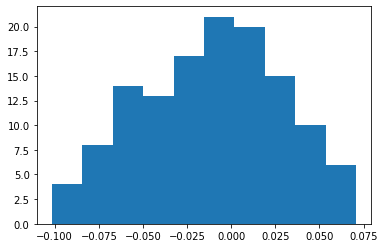

In [8]:
# conv 2.0
lines = 4
rows = 16
feature_map = 127

param = 'dconv_down2.0'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map)
mean_activation_histogram(param)

torch.Size([128, 128, 3, 3])


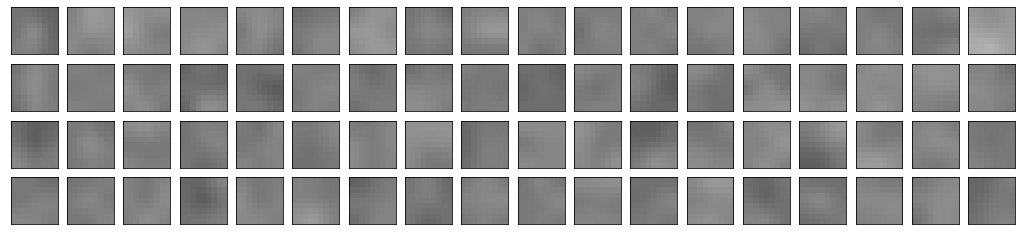

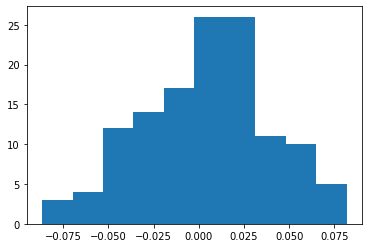

In [9]:
# conv 2.2
lines = 4
rows = 18
feature_map = 127

param = 'dconv_down2.2'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map)
mean_activation_histogram(param)

torch.Size([256, 128, 3, 3])


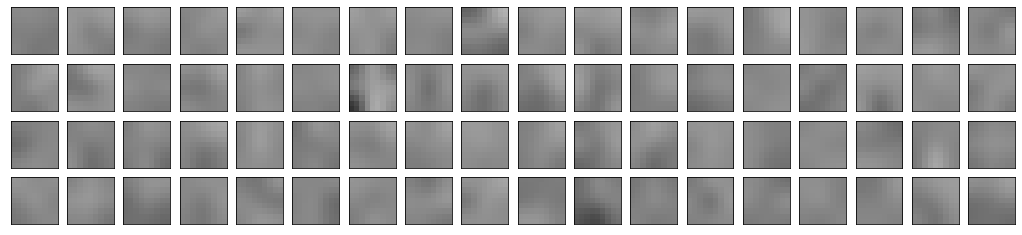

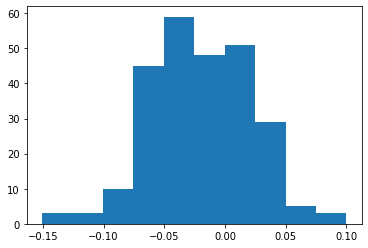

In [10]:
# conv 3.0
lines = 4
rows = 18
feature_map = 255

param = 'dconv_down3.0'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map)
mean_activation_histogram(param)

torch.Size([256, 256, 3, 3])


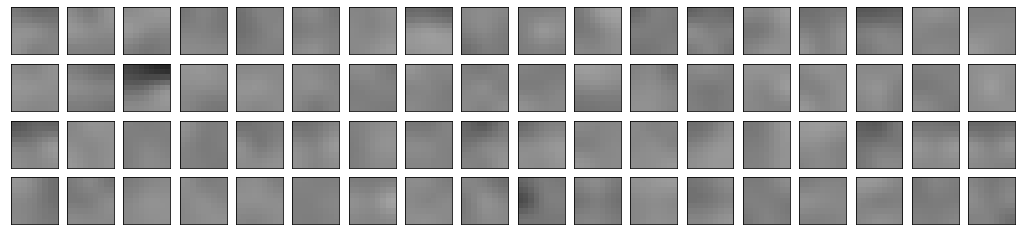

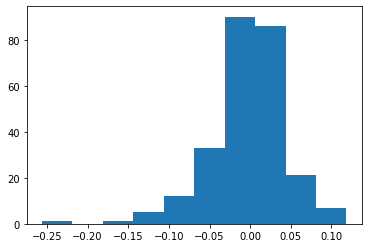

In [11]:
# conv 3.2
lines = 4
rows = 18
feature_map = 255

param = 'dconv_down3.2'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map)
mean_activation_histogram(param)

torch.Size([512, 256, 3, 3])


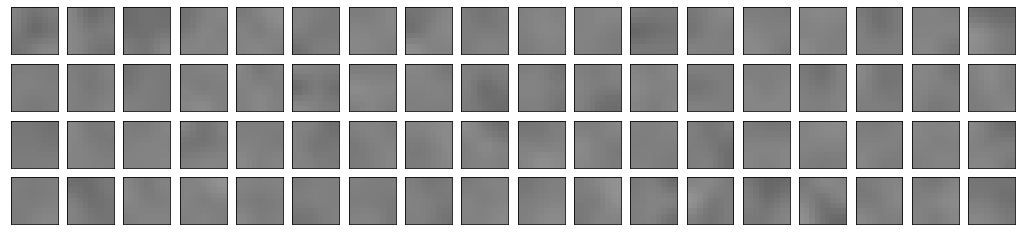

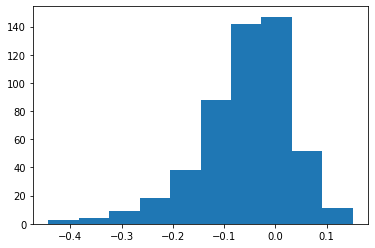

In [12]:
# conv 4.0
lines = 4
rows = 18
feature_map = 511

param = 'dconv_down4.0'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map)
mean_activation_histogram(param)

## Deconv kernels

In [13]:
model

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

torch.Size([256, 768, 3, 3])


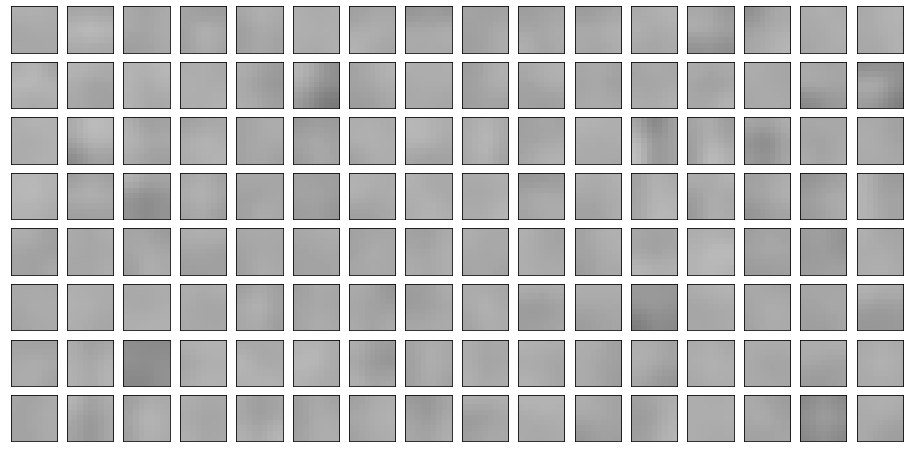

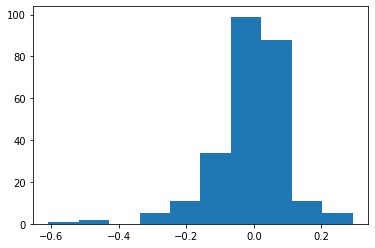

In [14]:
# upconv 3.0
lines = 8
rows = 16
feature_map = 0

param = 'dconv_up3.0'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map, deconv=False)
mean_activation_histogram(param, deconv=False)

torch.Size([256, 256, 3, 3])


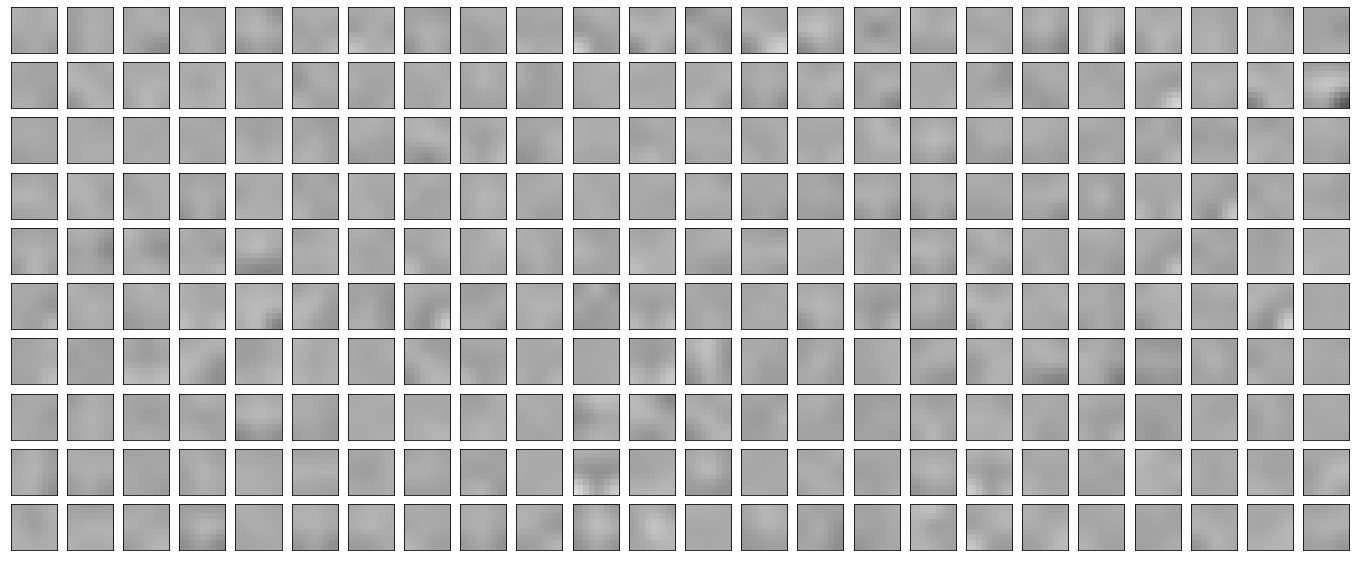

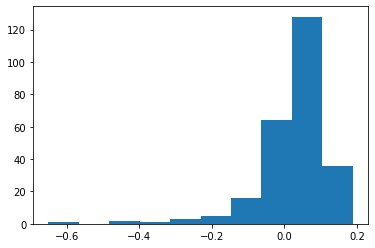

In [15]:
# upconv 3.2
lines = 10
rows = 24
feature_map = 0

param = 'dconv_up3.2'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map, deconv=False)
mean_activation_histogram(param, deconv=False)

torch.Size([128, 384, 3, 3])


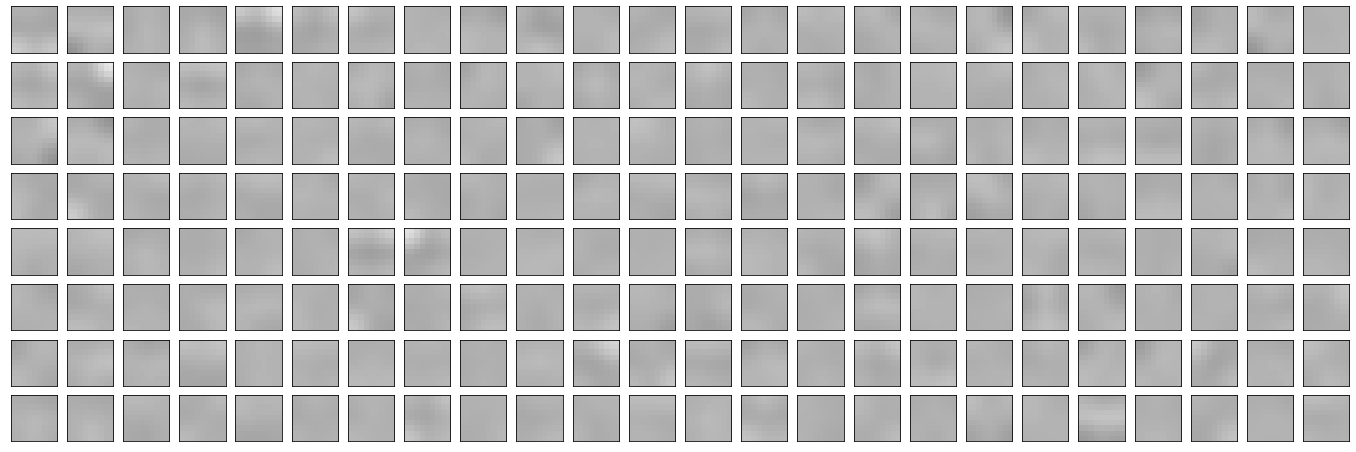

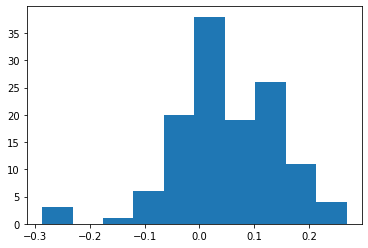

In [16]:
lines = 8
rows = 24
feature_map = 0

param = 'dconv_up2.0'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map, deconv=False)
mean_activation_histogram(param, deconv=False)

torch.Size([128, 128, 3, 3])


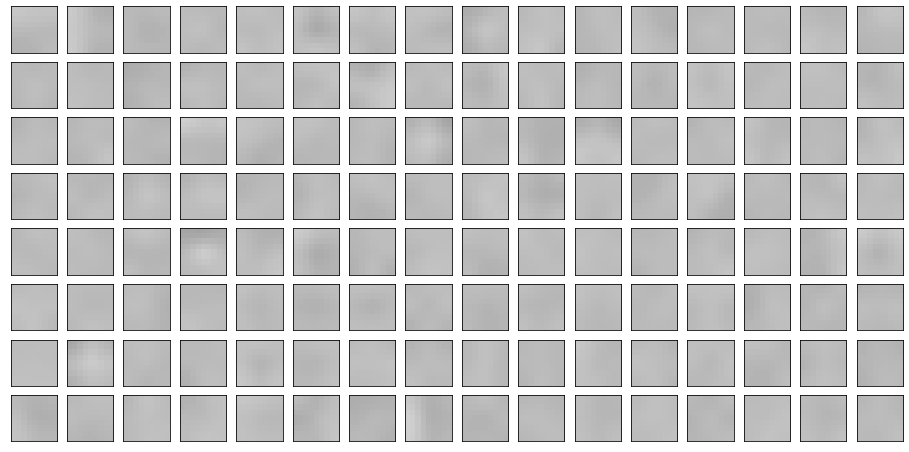

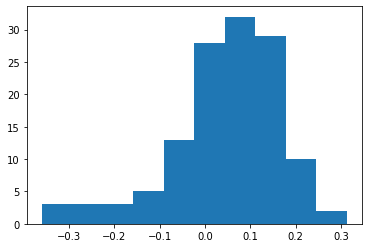

In [17]:
lines = 8
rows = 16
feature_map = 0

param = 'dconv_up2.2'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map, deconv=False)
mean_activation_histogram(param, deconv=False)

torch.Size([64, 192, 3, 3])


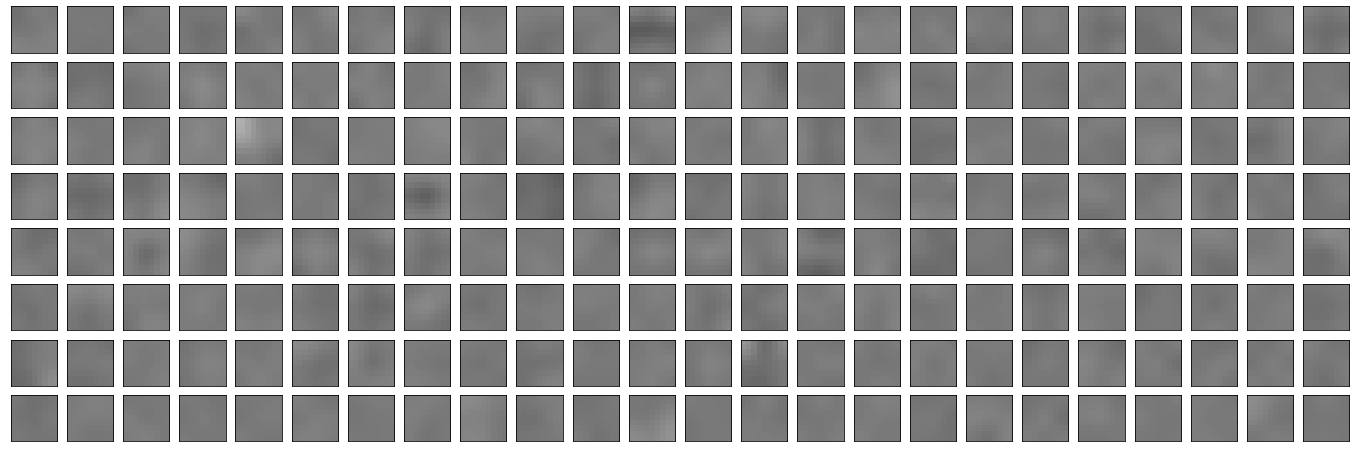

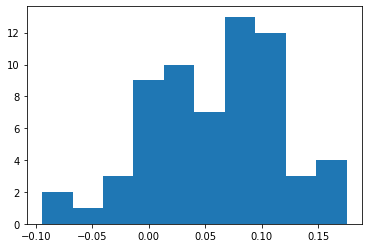

In [18]:
lines = 8
rows = 24
feature_map = 0

param = 'dconv_up1.0'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map, deconv=False)
mean_activation_histogram(param, deconv=False)

torch.Size([64, 64, 3, 3])


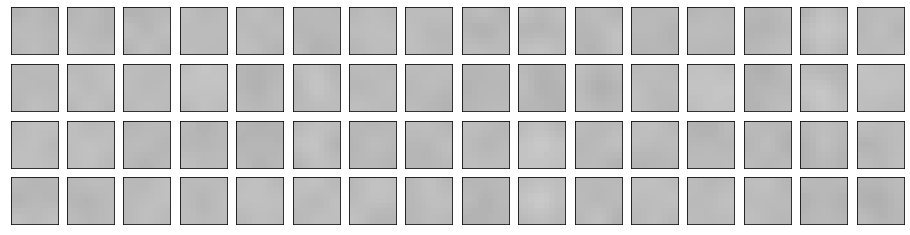

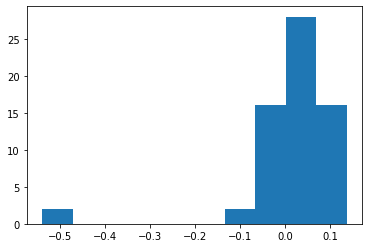

In [19]:
lines = 4
rows = 16
feature_map = 22

param = 'dconv_up1.2'
show_kernels(param, lines, rows, interp='none', feature_map=feature_map, deconv=False)
mean_activation_histogram(param, deconv=False)

torch.Size([20, 64, 1, 1])


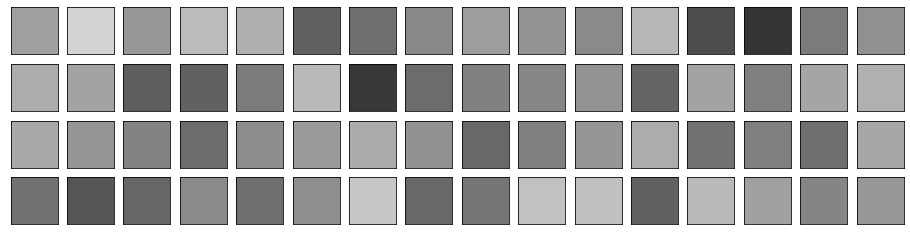

torch.Size([20, 64, 1, 1])


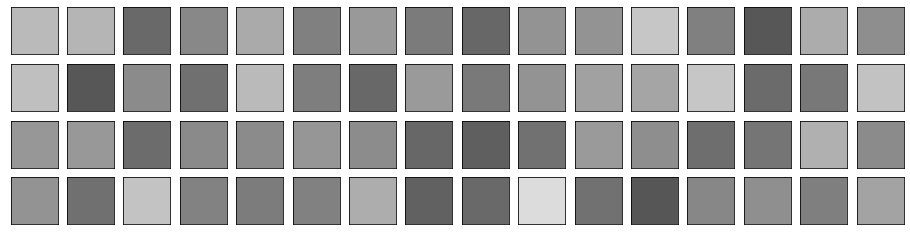

torch.Size([20, 64, 1, 1])


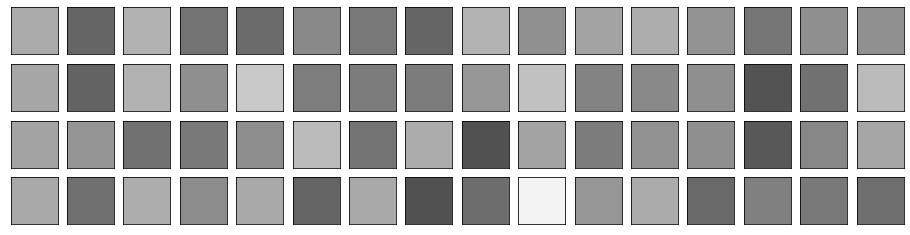

torch.Size([20, 64, 1, 1])


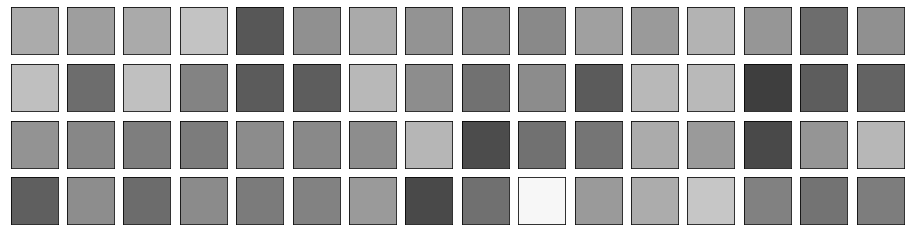

torch.Size([20, 64, 1, 1])


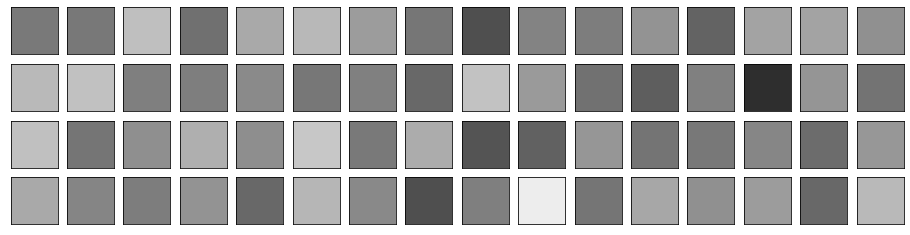

torch.Size([20, 64, 1, 1])


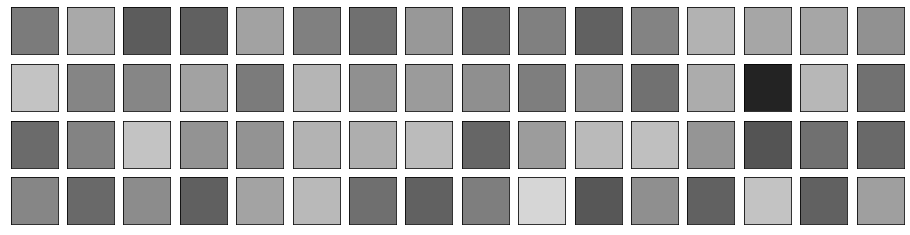

torch.Size([20, 64, 1, 1])


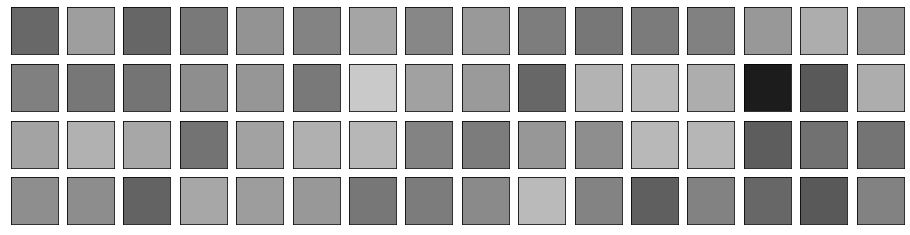

torch.Size([20, 64, 1, 1])


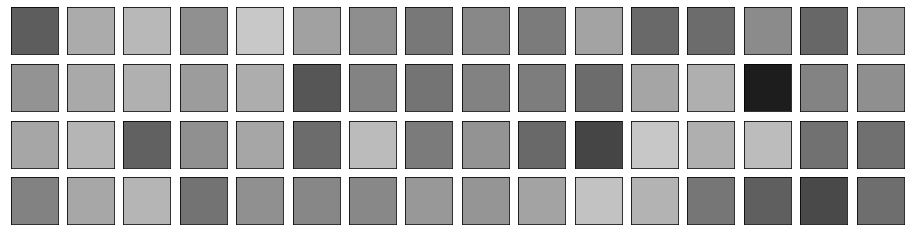

torch.Size([20, 64, 1, 1])


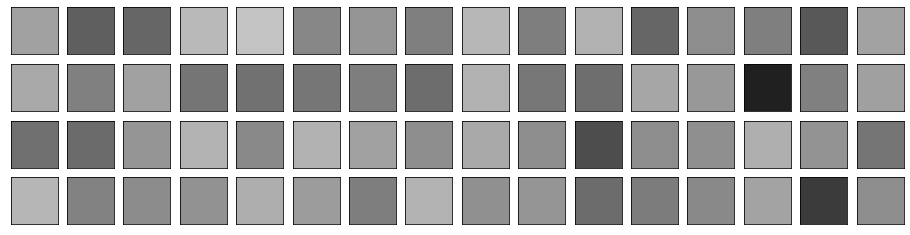

torch.Size([20, 64, 1, 1])


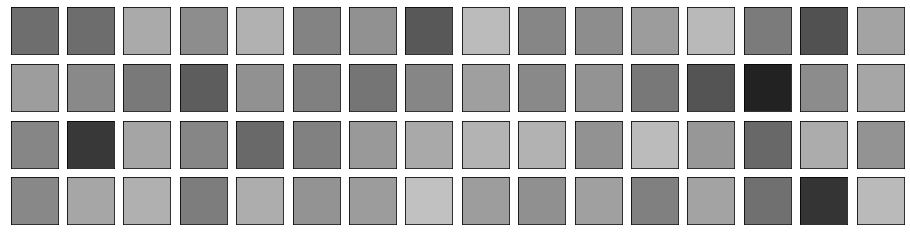

torch.Size([20, 64, 1, 1])


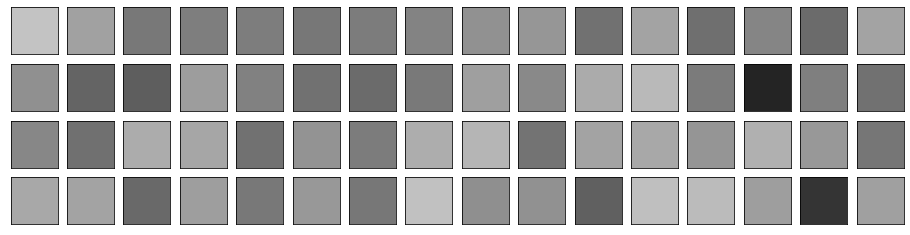

torch.Size([20, 64, 1, 1])


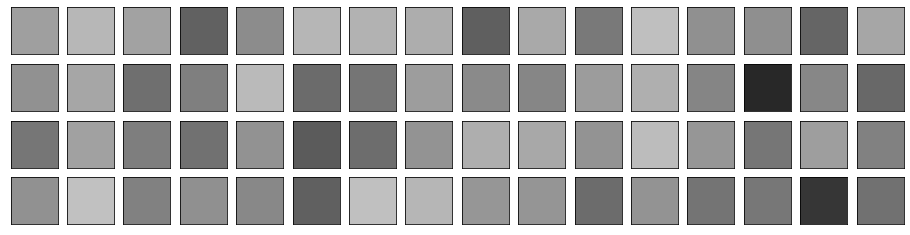

torch.Size([20, 64, 1, 1])


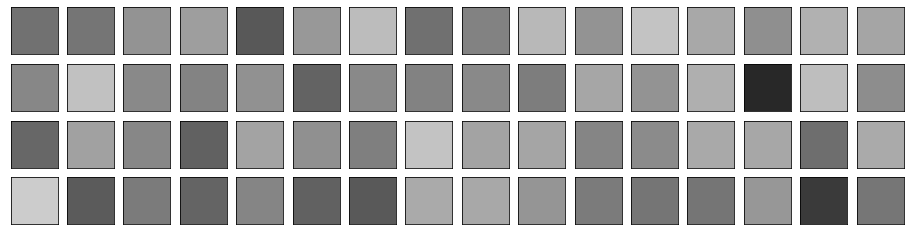

torch.Size([20, 64, 1, 1])


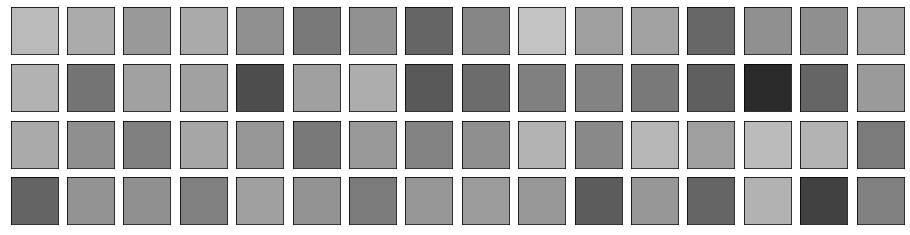

torch.Size([20, 64, 1, 1])


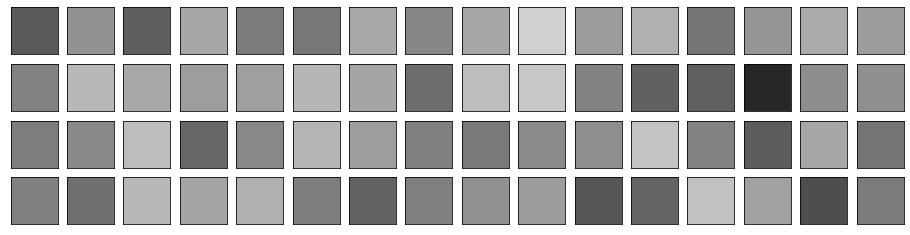

torch.Size([20, 64, 1, 1])


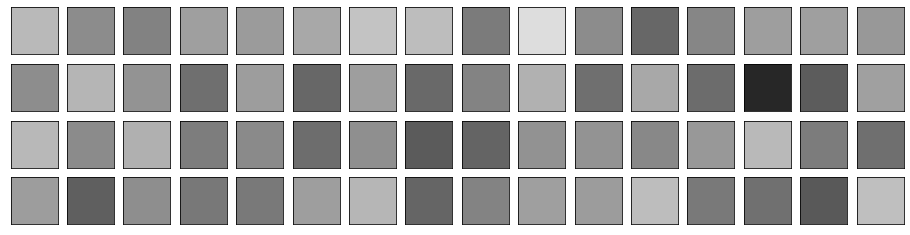

torch.Size([20, 64, 1, 1])


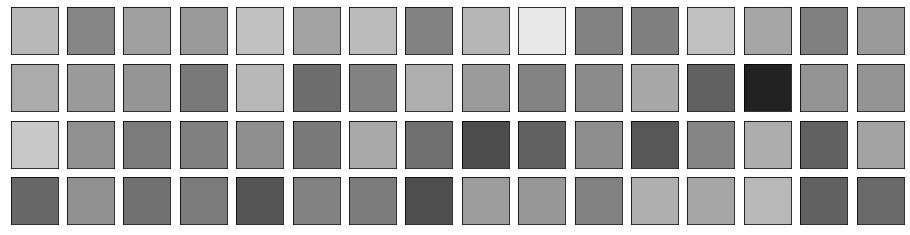

torch.Size([20, 64, 1, 1])


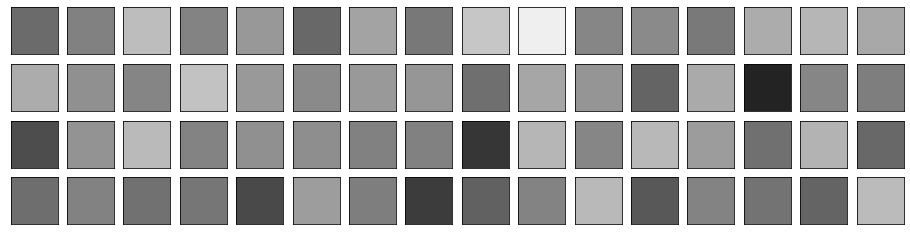

torch.Size([20, 64, 1, 1])


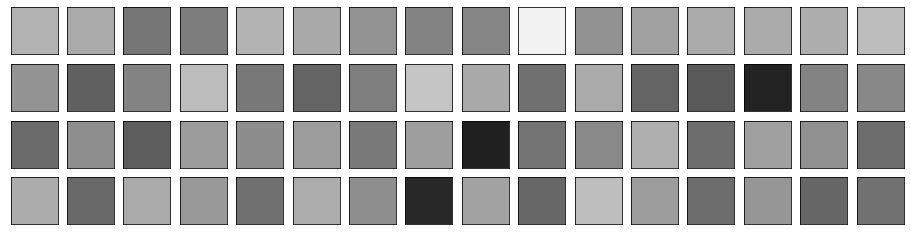

torch.Size([20, 64, 1, 1])


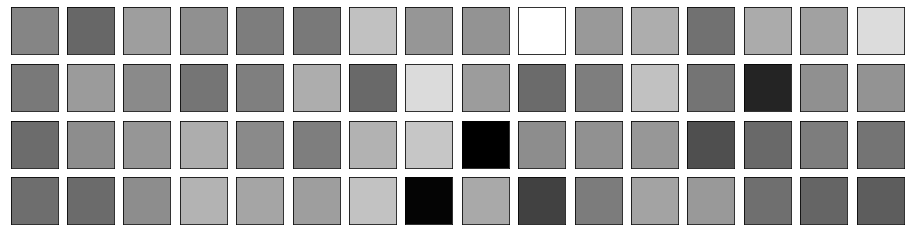

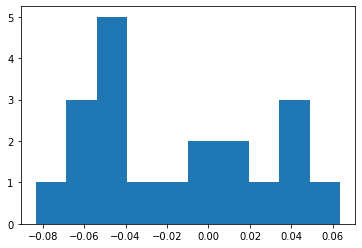

In [20]:
lines = 4
rows = 16
feature_map = 0

param = 'conv_last'
for feature_map in range(20):
    show_kernels(param, lines, rows, interp='none', feature_map=feature_map, deconv=False, zoom=1)
mean_activation_histogram(param, deconv=False)

In [21]:
import plotly
plotly.__version__

'4.2.1'

# Visualize feature maps

In [23]:
# Visualize feature maps
activation = {}
hooks = {}

In [24]:
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output #.detach()
#         print(name)
    return hook

In [25]:
for n,h in hooks.items():
    h.remove()

for name, module in model.named_modules():
    hooks[name] = module.register_forward_hook(get_activation(name))

In [181]:
# 'Test_1', 'Test_2', 'Test_3', 
# 'Lines_1', 'Lines_2', 'Lines_3',
# 'Double_Drop_1', 'Double_Drop_2', 'Double_Drop_3', 
# 'Illumination_135_1', 'Illumination_135_2', 'Illumination_135_3', 
# 'Illumination_Random_1', 'Illumination_Random_2', 'Illumination_Random_3', 
# 'Shallow_Depth_1', 'Shallow_Depth_2', 'Shallow_Depth_3', 
# 'Smaller_Tub_1', 'Smaller_Tub_2', 'Smaller_Tub_3', 
# 'Bigger_Tub_1', 'Bigger_Tub_2', 'Bigger_Tub_3', 
# 'Fixed_Tub_1', 'Fixed_Tub_2', 'Fixed_Tub_3'

test_set = 'Test_1'
batch_images = batch_images_all[test_set]

starting_point = 10
num_total_output_frames = 80
batch_index=0
model.eval()
num_input_frames = model.get_num_input_frames()
with torch.no_grad():
    input_end_point = starting_point + num_input_frames
    input_frames = batch_images[batch_index:batch_index+1, starting_point:input_end_point, :, :].clone()
    output_frames = model.get_future_frames(input_frames, num_total_output_frames, belated=True)
    target_frames = batch_images[batch_index:batch_index+1, input_end_point:(input_end_point + num_total_output_frames), :, :]
    
output_frames = image_prepro(output_frames, experiment.normalizer)
target_frames = image_prepro(target_frames, experiment.normalizer)
input_frames = image_prepro(input_frames, experiment.normalizer)

output_frames.size()

torch.Size([1, 80, 128, 128])

In [177]:
input_frames.size()

torch.Size([1, 5, 128, 128])

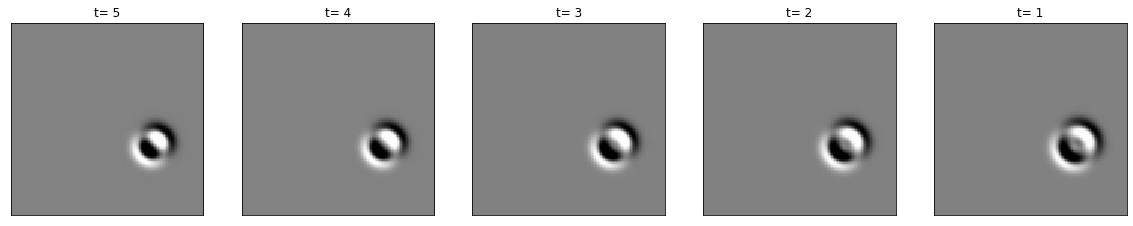

In [178]:
fig, ax = plt.subplots(1, 5, figsize = (20, 4))

for t in range(5):
    ax[t].imshow(input_frames[0, t, :, :], cmap='gray', vmin=0, vmax=1)
    ax[t].set_title('t= %d' % (5-t))
    ax[t].get_xaxis().set_ticks([])
    ax[t].get_yaxis().set_ticks([])
plt.show()

In [146]:
activation.keys()

dict_keys(['dconv_down1.0', 'dconv_down1.1', 'dconv_down1.2', 'dconv_down1.3', 'dconv_down1', 'maxpool', 'dconv_down2.0', 'dconv_down2.1', 'dconv_down2.2', 'dconv_down2.3', 'dconv_down2', 'dconv_down3.0', 'dconv_down3.1', 'dconv_down3.2', 'dconv_down3.3', 'dconv_down3', 'dconv_down4.0', 'dconv_down4.1', 'dconv_down4.2', 'dconv_down4.3', 'dconv_down4', 'dconv_up3.0', 'dconv_up3.1', 'dconv_up3.2', 'dconv_up3.3', 'dconv_up3', 'dconv_up2.0', 'dconv_up2.1', 'dconv_up2.2', 'dconv_up2.3', 'dconv_up2', 'dconv_up1.0', 'dconv_up1.1', 'dconv_up1.2', 'dconv_up1.3', 'dconv_up1', 'conv_last', ''])

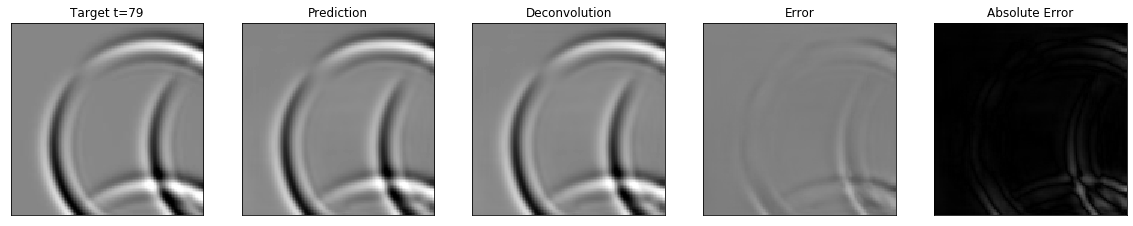

Deconv and Prediction error (should be zero): 0.000000
prediction error 0.025900


In [147]:
deconv_name = 'conv_last'
dconv_norm = image_prepro(activation[deconv_name].squeeze()[-1,:], experiment.normalizer)

t=num_total_output_frames-1
fig, ax = plt.subplots(1, 5, figsize = (20, 4))
ax[0].imshow(target_frames[0, t, :, :], cmap='gray', vmin=0, vmax=1)
ax[1].imshow(output_frames[0, t, :, :], cmap='gray', vmin=0, vmax=1)
ax[2].imshow(dconv_norm, cmap='gray', vmin=0, vmax=1)
ax[3].imshow((target_frames[0, t, :, :] - output_frames[0, t, :, :]), cmap='gray', vmin=-1, vmax=1)
ax[4].imshow(abs(target_frames[0, t, :, :] - output_frames[0, t, :, :]), cmap='gray', vmin=0, vmax=1)

ax[0].set_title('Target t=%d'%t)
ax[1].set_title('Prediction')
ax[2].set_title('Deconvolution')
ax[3].set_title('Error')
ax[4].set_title('Absolute Error')

for a in ax:
    a.get_xaxis().set_ticks([])
    a.get_yaxis().set_ticks([])
plt.show()

print('Deconv and Prediction error (should be zero): %f' % (output_frames[0, t, :, :] - dconv_norm).abs().mean())
print("prediction error %f" % (target_frames[0, t, :, :] - dconv_norm).abs().mean())

In [148]:
for k,v in activation.items():
    try:
        print(k, v.size())
    except:
        pass

dconv_down1.0 torch.Size([1, 64, 128, 128])
dconv_down1.1 torch.Size([1, 64, 128, 128])
dconv_down1.2 torch.Size([1, 64, 128, 128])
dconv_down1.3 torch.Size([1, 64, 128, 128])
dconv_down1 torch.Size([1, 64, 128, 128])
maxpool torch.Size([1, 256, 16, 16])
dconv_down2.0 torch.Size([1, 128, 64, 64])
dconv_down2.1 torch.Size([1, 128, 64, 64])
dconv_down2.2 torch.Size([1, 128, 64, 64])
dconv_down2.3 torch.Size([1, 128, 64, 64])
dconv_down2 torch.Size([1, 128, 64, 64])
dconv_down3.0 torch.Size([1, 256, 32, 32])
dconv_down3.1 torch.Size([1, 256, 32, 32])
dconv_down3.2 torch.Size([1, 256, 32, 32])
dconv_down3.3 torch.Size([1, 256, 32, 32])
dconv_down3 torch.Size([1, 256, 32, 32])
dconv_down4.0 torch.Size([1, 512, 16, 16])
dconv_down4.1 torch.Size([1, 512, 16, 16])
dconv_down4.2 torch.Size([1, 512, 16, 16])
dconv_down4.3 torch.Size([1, 512, 16, 16])
dconv_down4 torch.Size([1, 512, 16, 16])
dconv_up3.0 torch.Size([1, 256, 32, 32])
dconv_up3.1 torch.Size([1, 256, 32, 32])
dconv_up3.2 torch.Size([

In [149]:
def print_activations(act_name, index_t, lines, rows):
    act = activation[act_name][index_t,:]
    print(act.size())
    fig, axarr = plt.subplots(lines, rows, figsize=(2*rows, 2*lines))
    for i in range(lines):
        for k in range(rows):
            a = i*rows +k
#             print(i,k,a)
            if (a < act.size(0)):
                axarr[i, k].imshow(act[a,:], cmap='gray', vmin=act.min(), vmax=act.max())
            axarr[i, k].set_yticks([])
            axarr[i, k].set_xticks([])
    plt.show()

torch.Size([64, 128, 128])


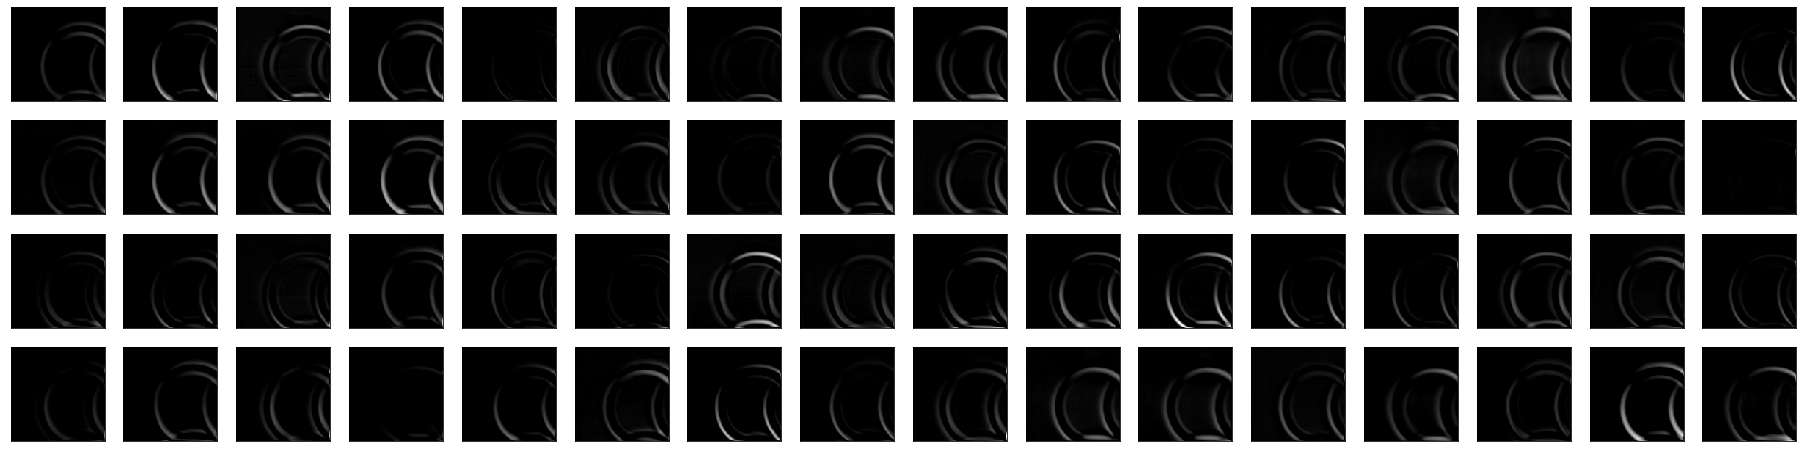

In [150]:
print_activations('dconv_down1.1', index_t=0,  lines = 4, rows = 16)

torch.Size([64, 128, 128])


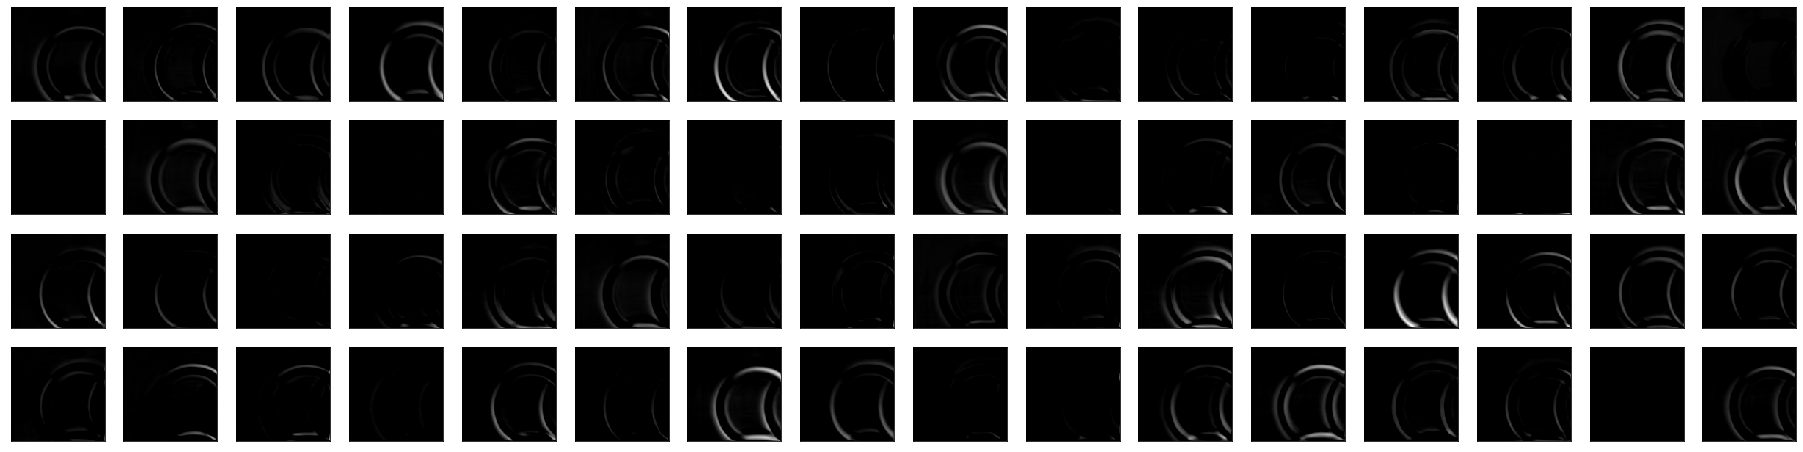

In [151]:
print_activations('dconv_down1.3', index_t=0,  lines = 4, rows = 16)

torch.Size([128, 64, 64])


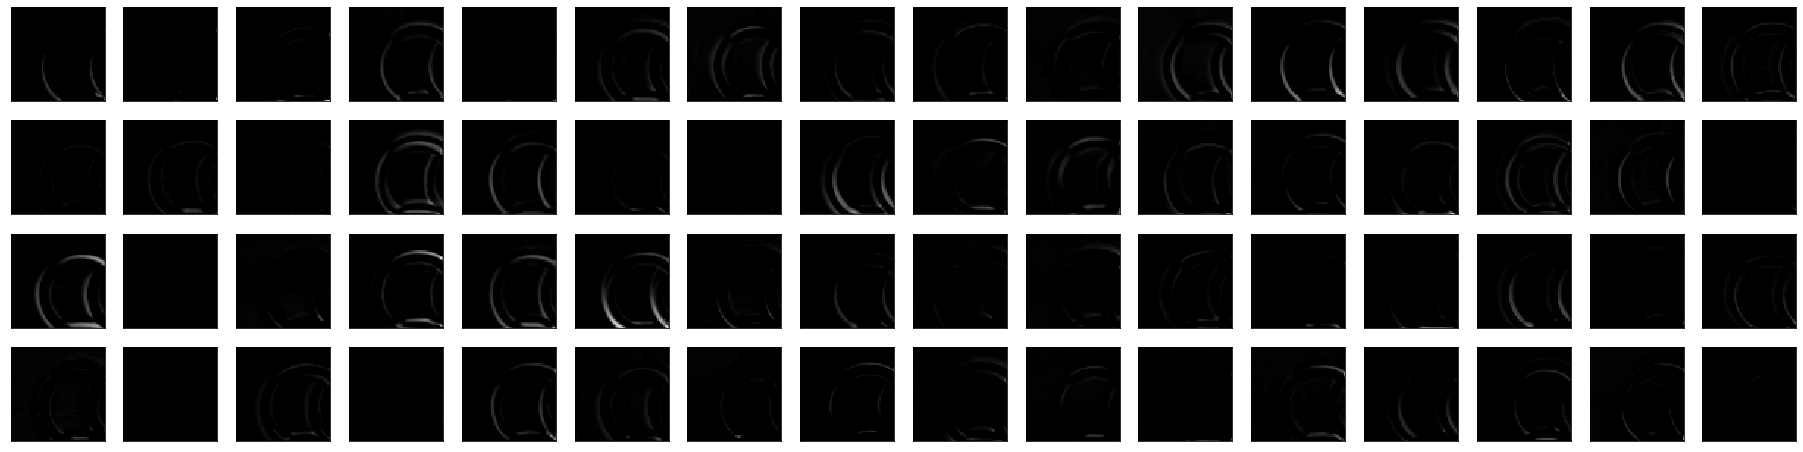

In [152]:
print_activations('dconv_down2.1', index_t=0,  lines = 4, rows = 16)

torch.Size([128, 64, 64])


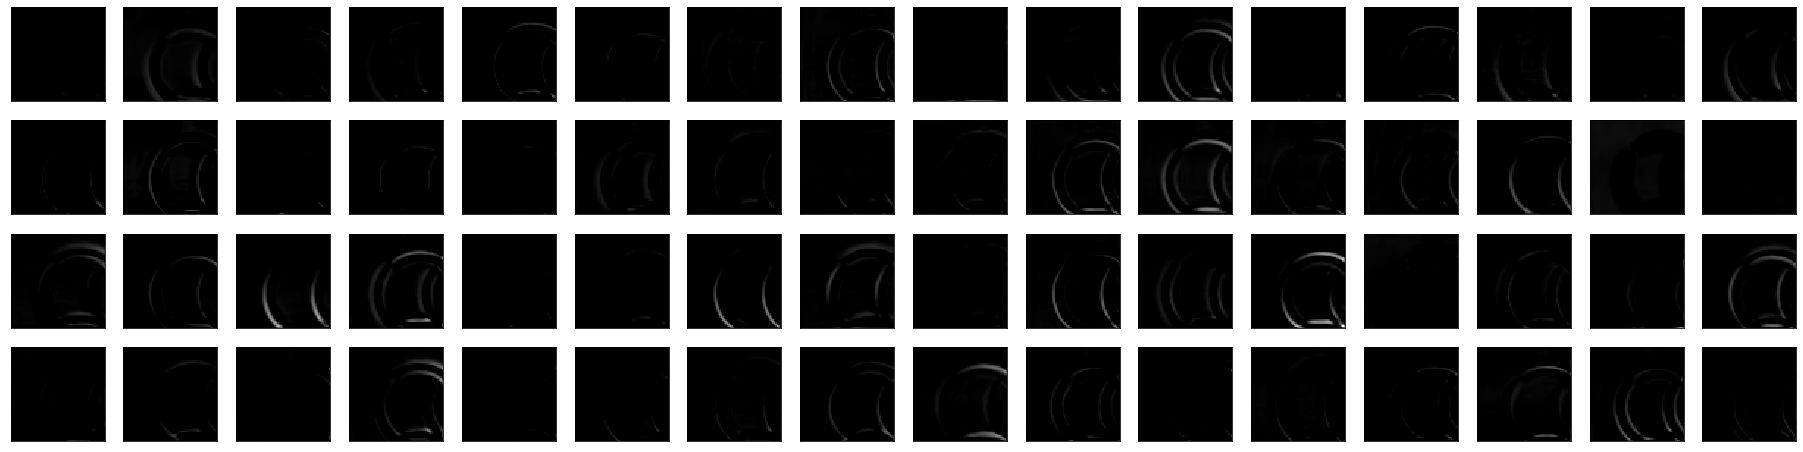

In [153]:
print_activations('dconv_down2.3', index_t=0,  lines = 4, rows = 16)

torch.Size([256, 32, 32])


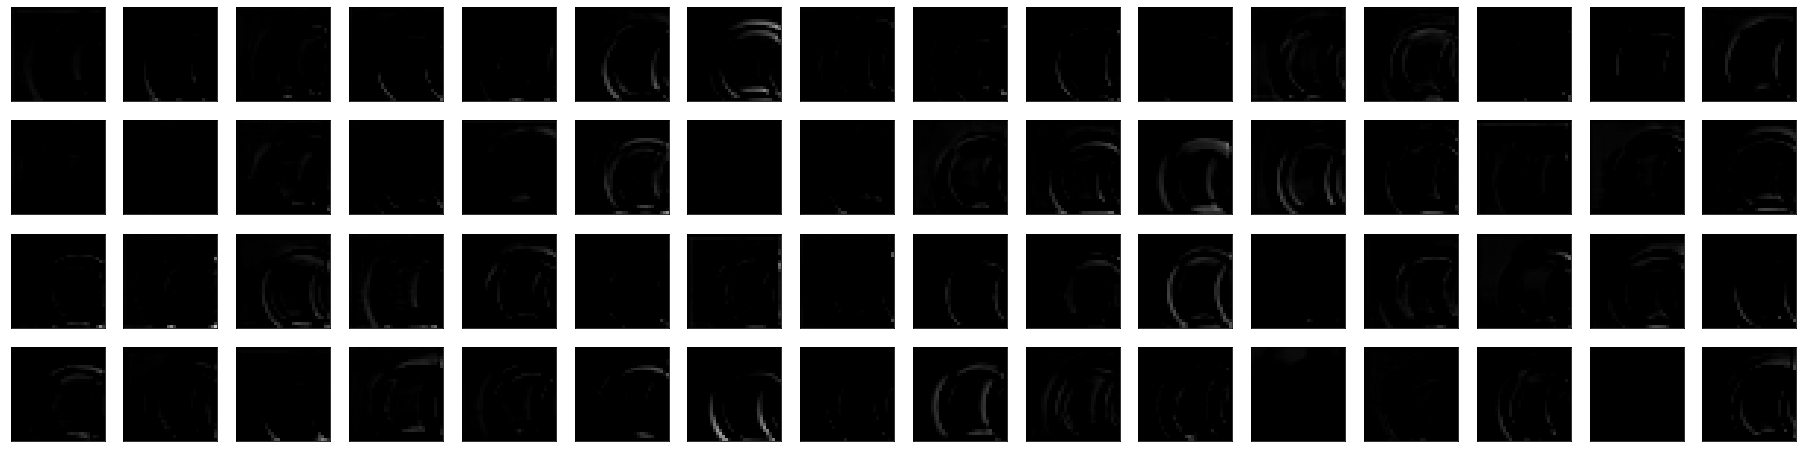

In [154]:
print_activations('dconv_down3.1', index_t=0,  lines = 4, rows = 16)

torch.Size([256, 32, 32])


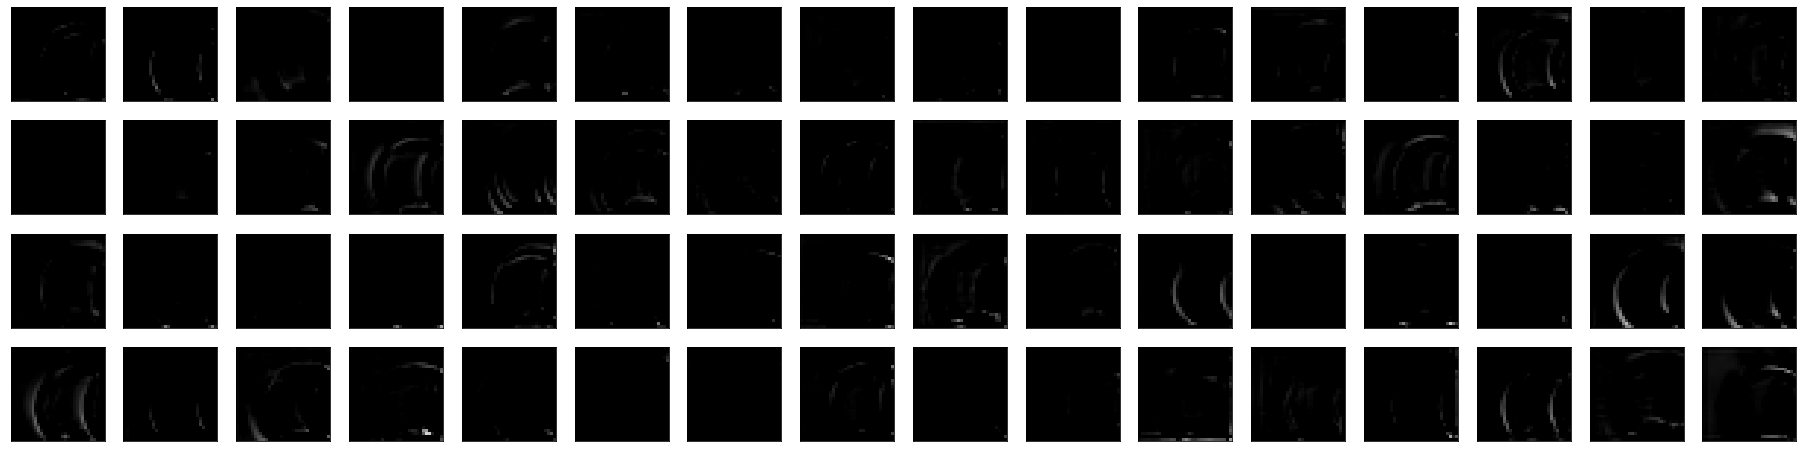

In [155]:
print_activations('dconv_down3.3', index_t=0,  lines = 4, rows = 16)

torch.Size([512, 16, 16])


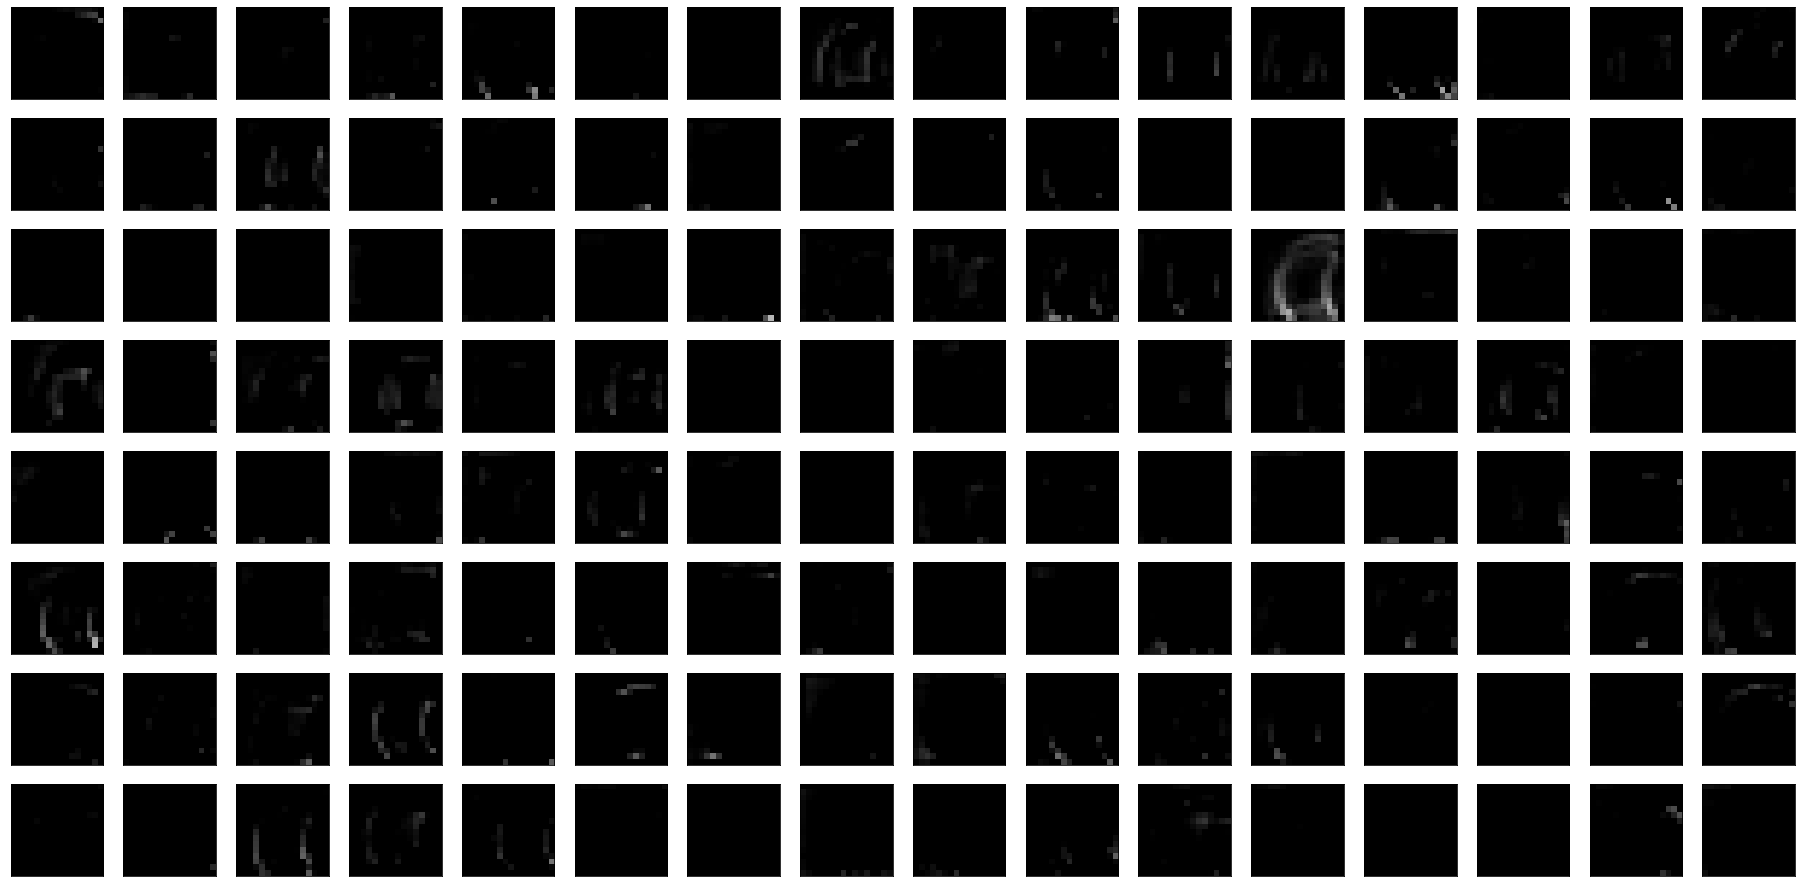

In [156]:
print_activations('dconv_down4.1', index_t=0,  lines = 8, rows = 16)

torch.Size([512, 16, 16])


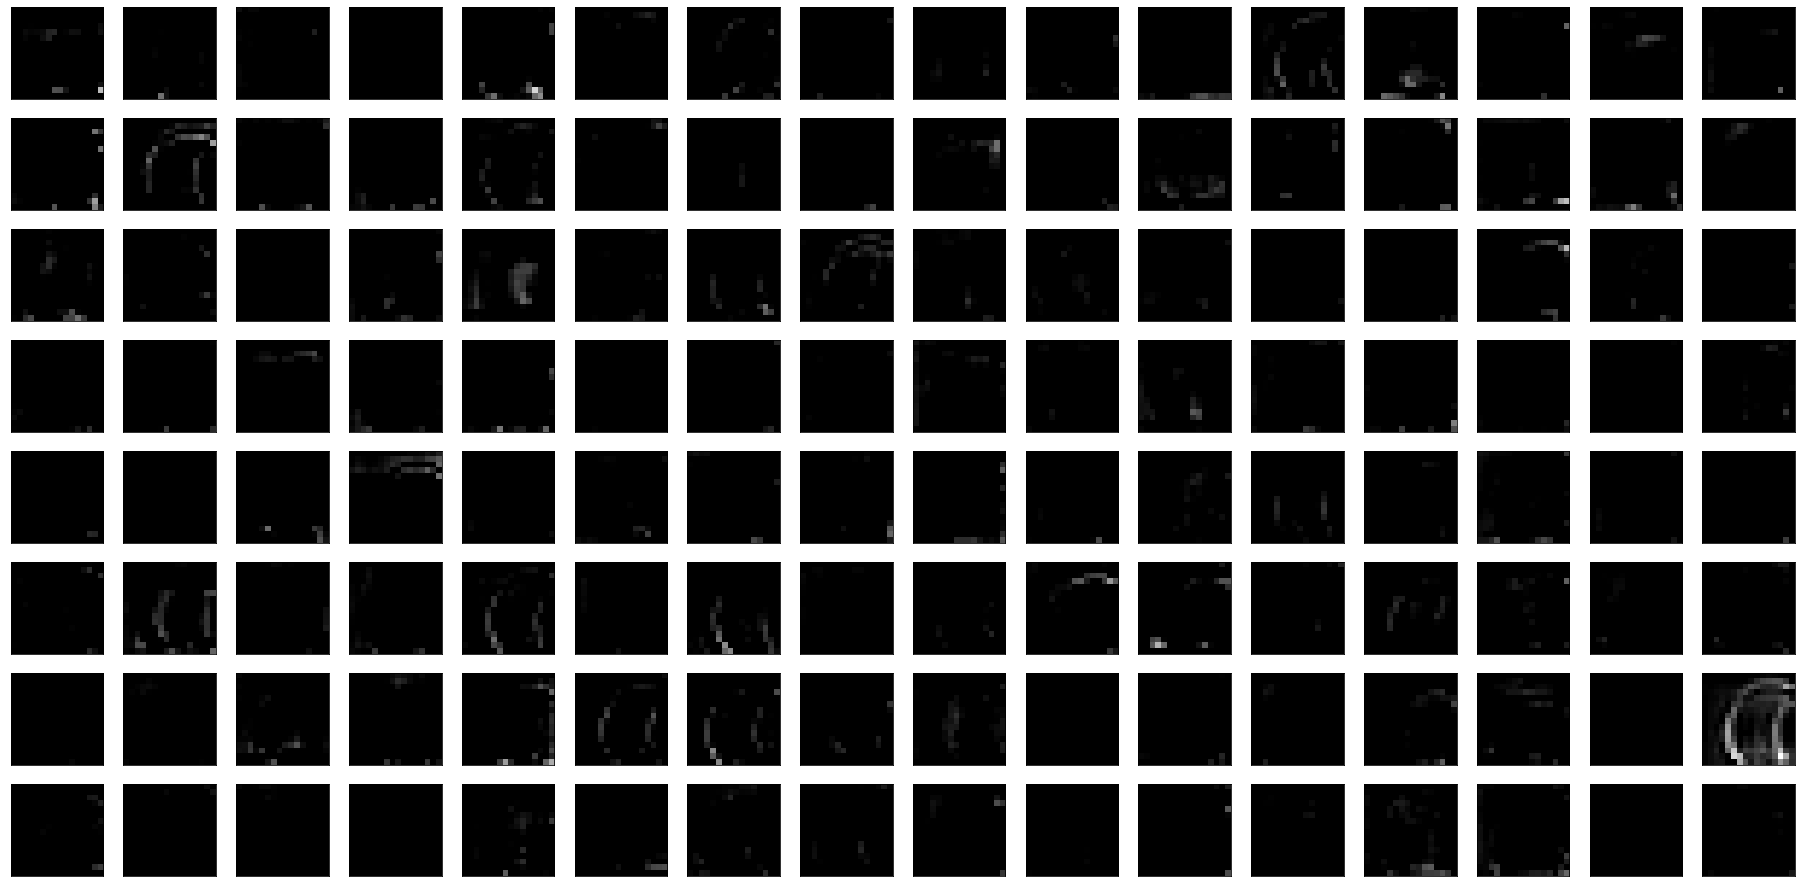

In [157]:
print_activations('dconv_down4.3', index_t=0,  lines = 8, rows = 16)

torch.Size([256, 32, 32])


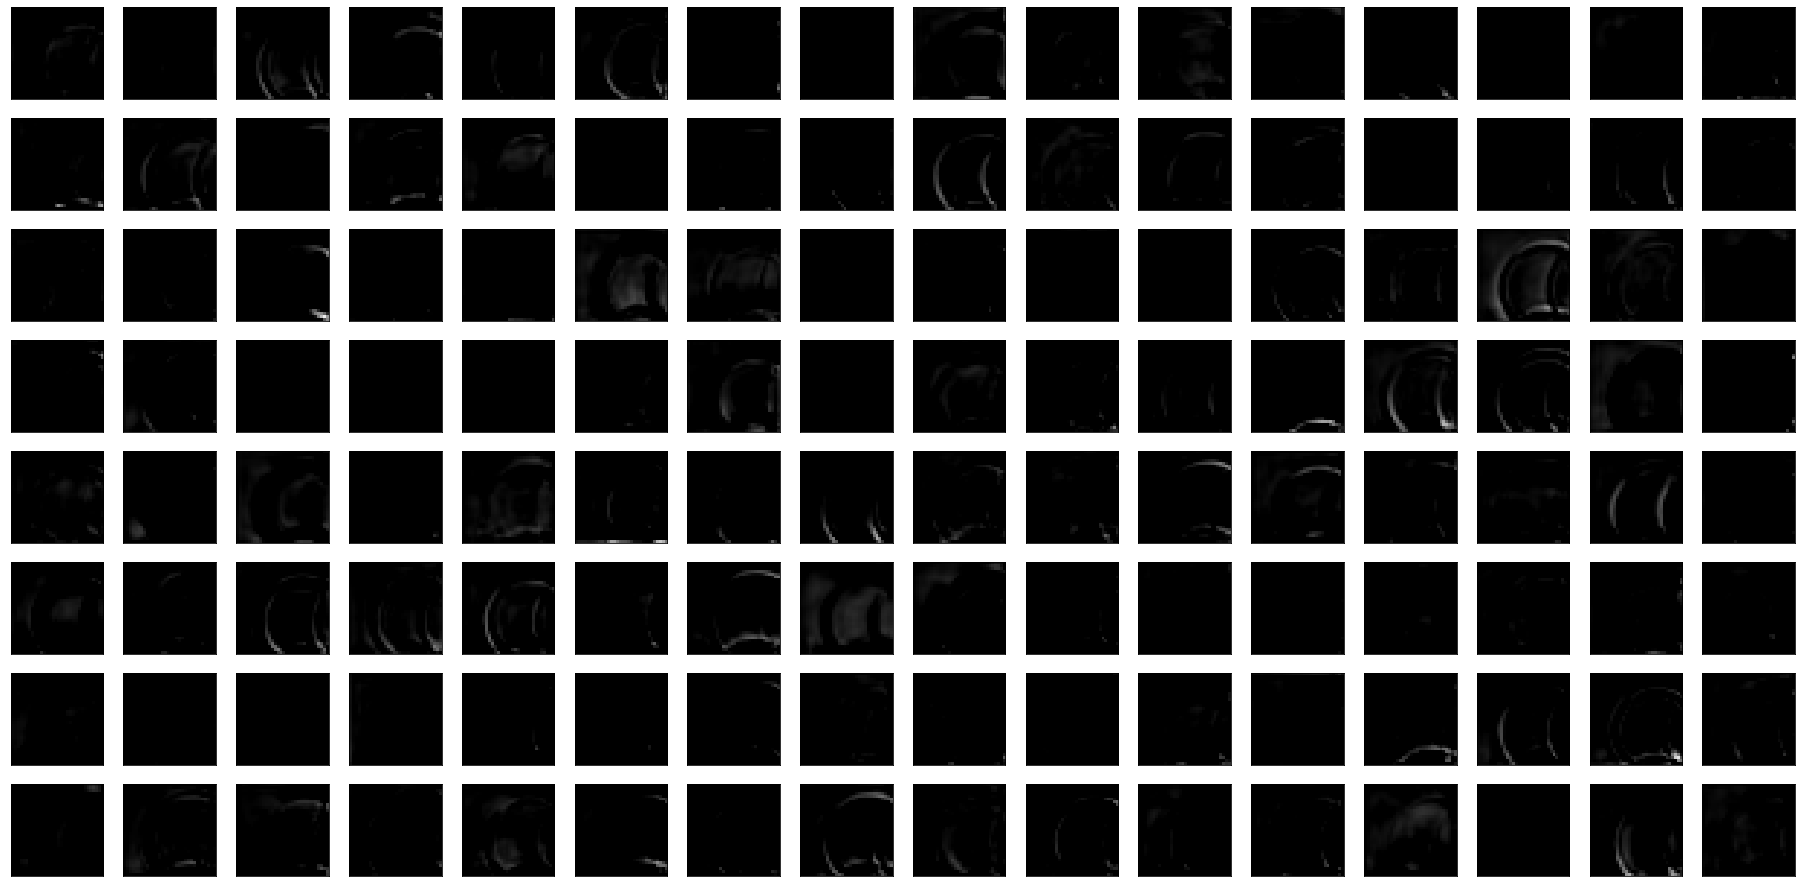

In [158]:
print_activations('dconv_up3.1', index_t=0,  lines = 8, rows = 16)

torch.Size([256, 32, 32])


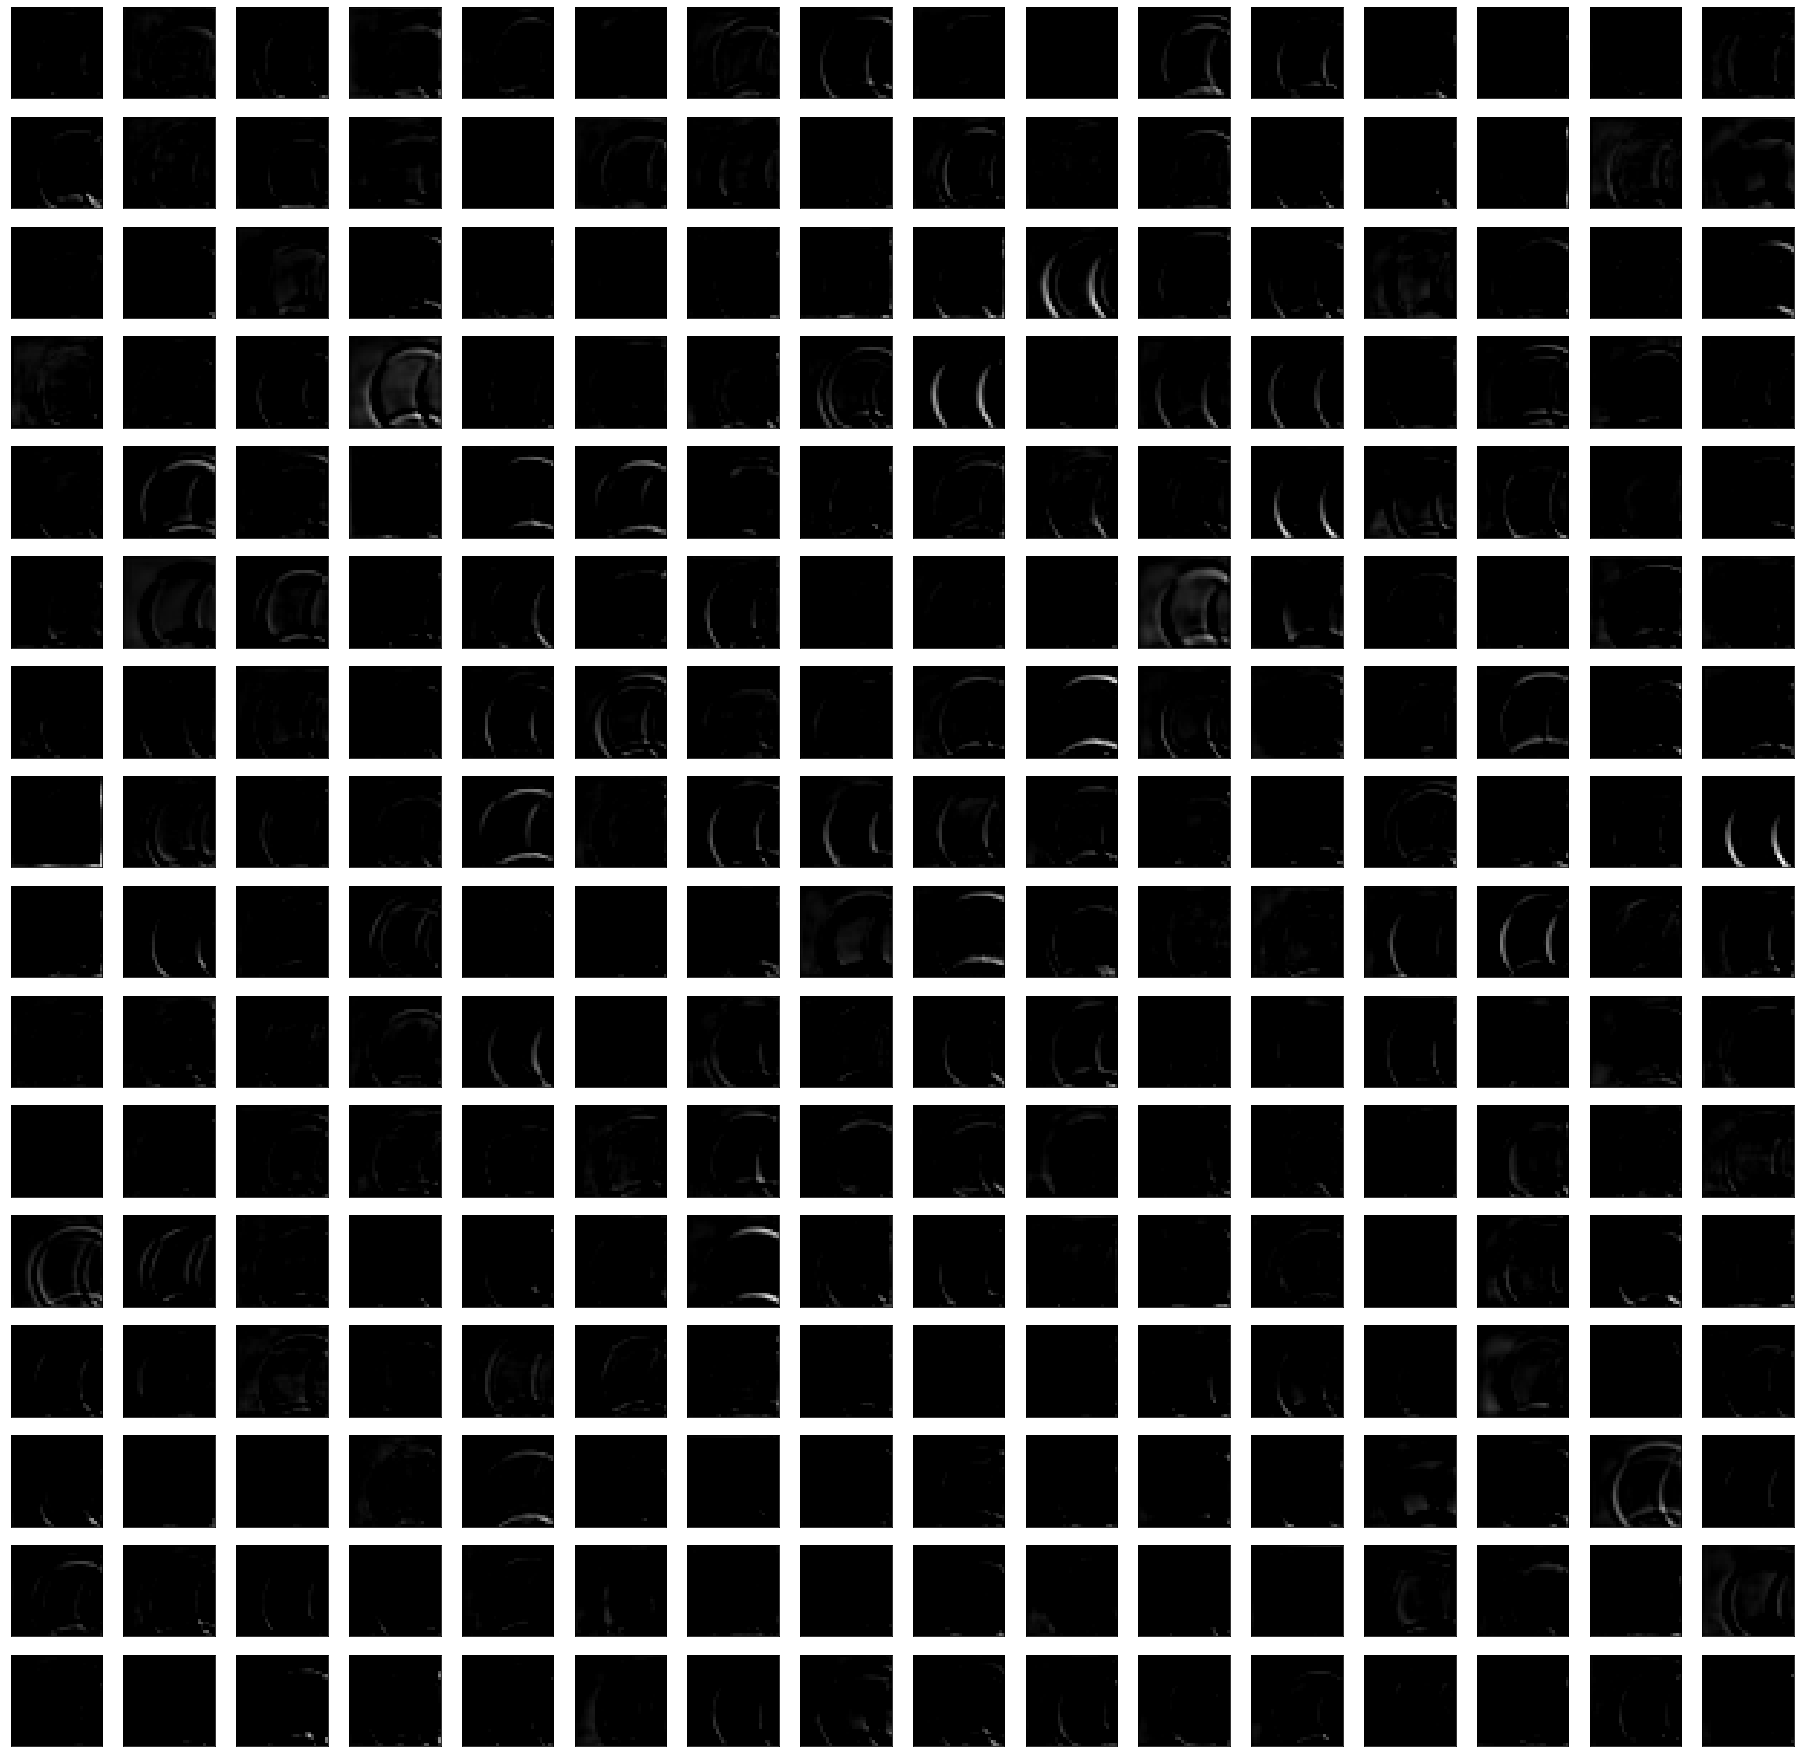

In [159]:
print_activations('dconv_up3.3', index_t=0,  lines = 16, rows = 16)

torch.Size([128, 64, 64])


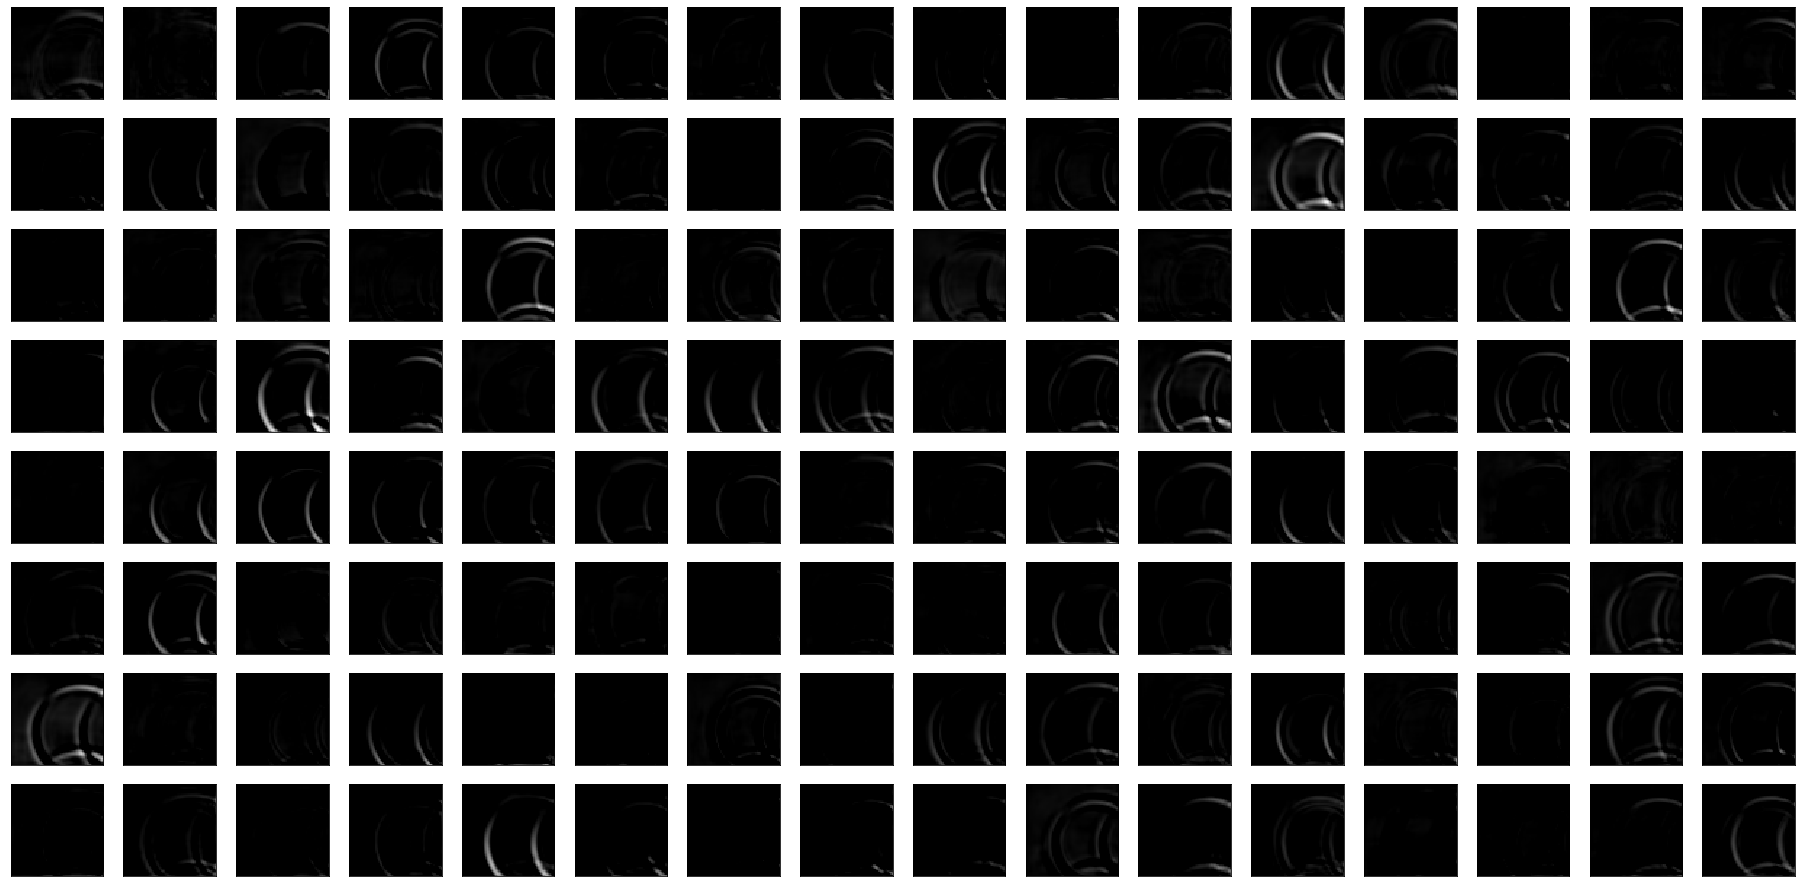

In [160]:
print_activations('dconv_up2.1', index_t=0,  lines = 8, rows = 16)

torch.Size([128, 64, 64])


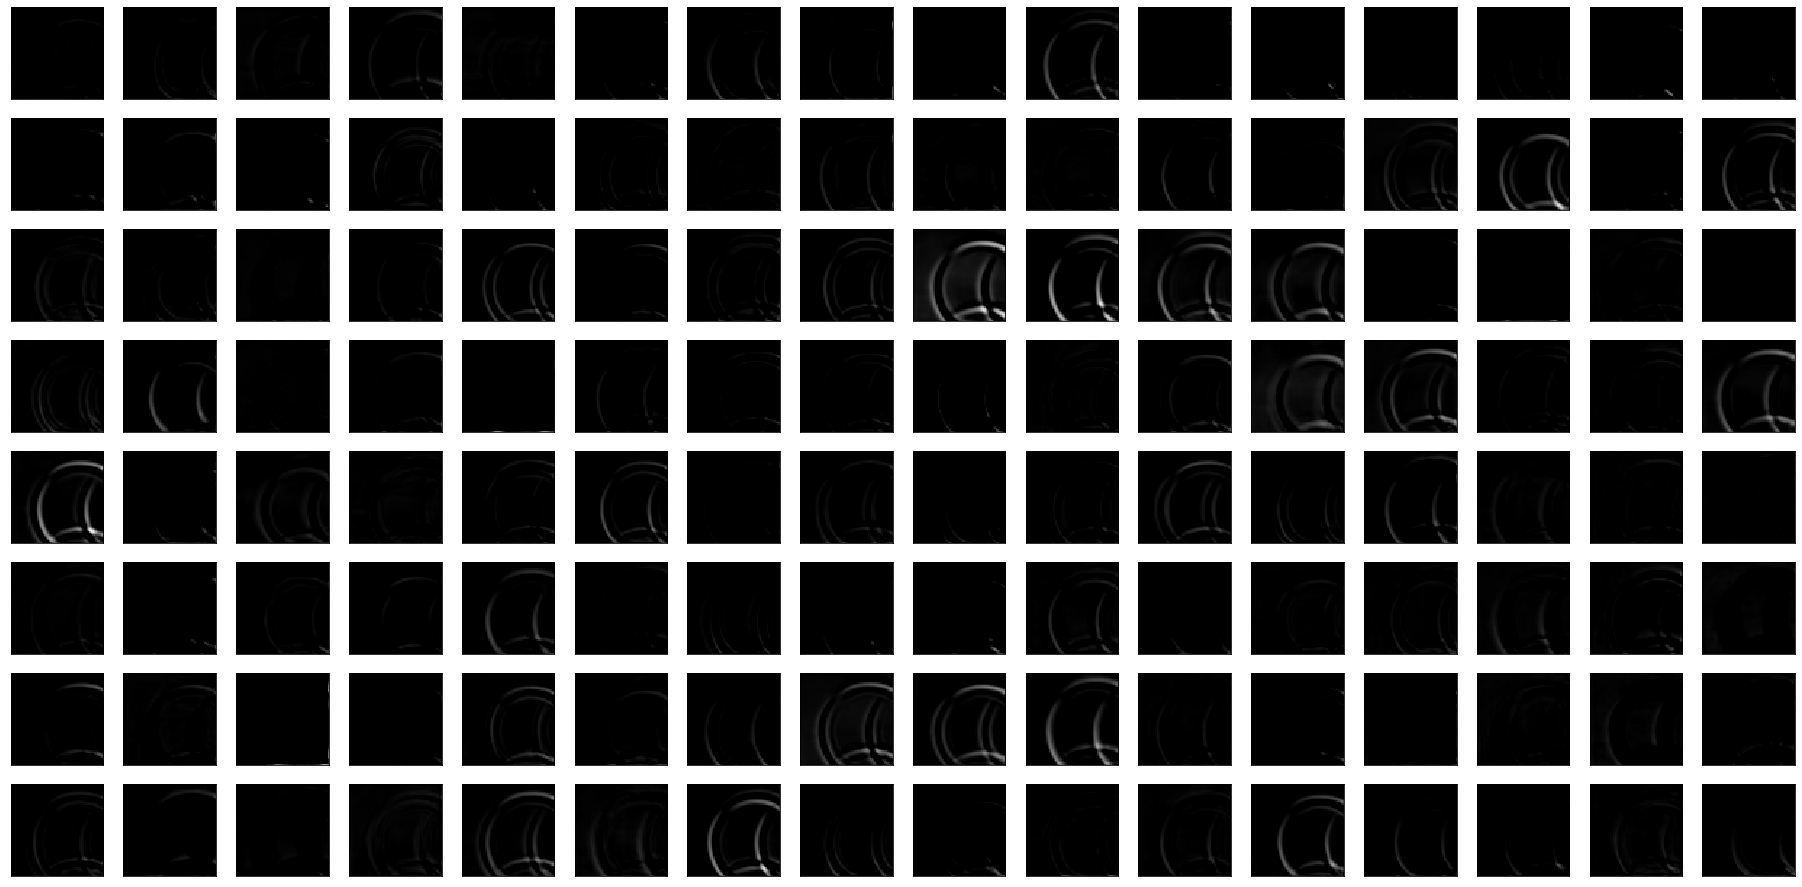

In [161]:
print_activations('dconv_up2.3', index_t=0,  lines = 8, rows = 16)

torch.Size([64, 128, 128])


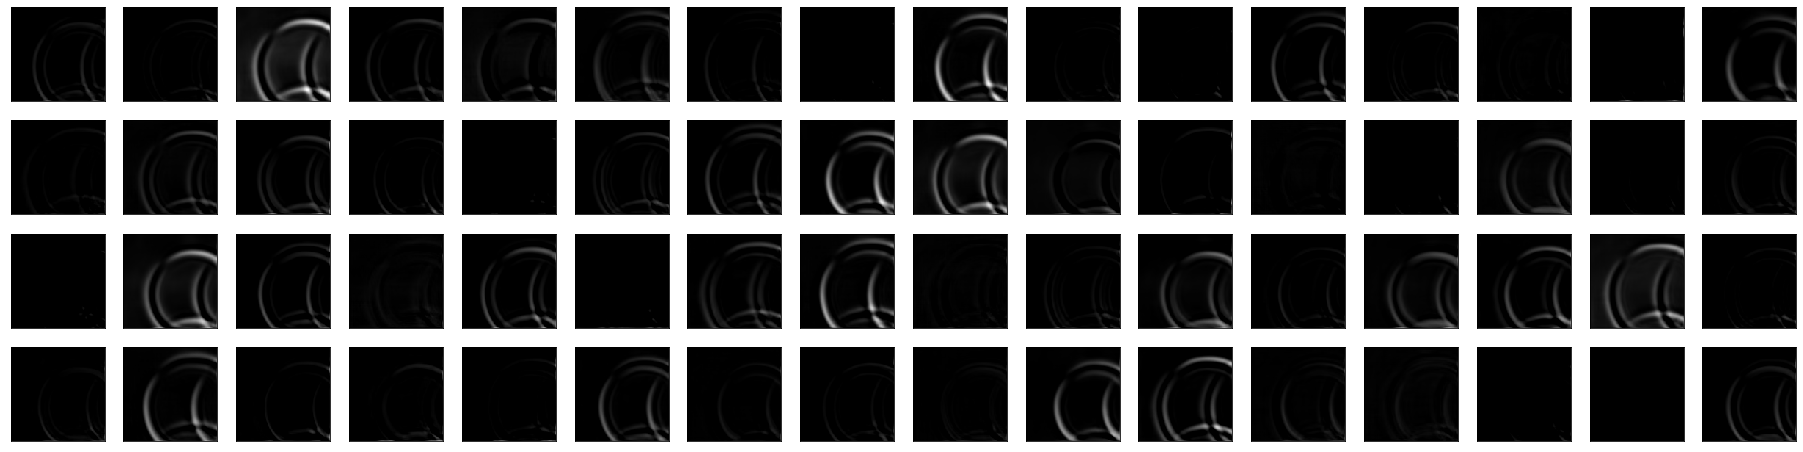

In [162]:
print_activations('dconv_up1.1', index_t=0,  lines = 4, rows = 16)

torch.Size([64, 128, 128])


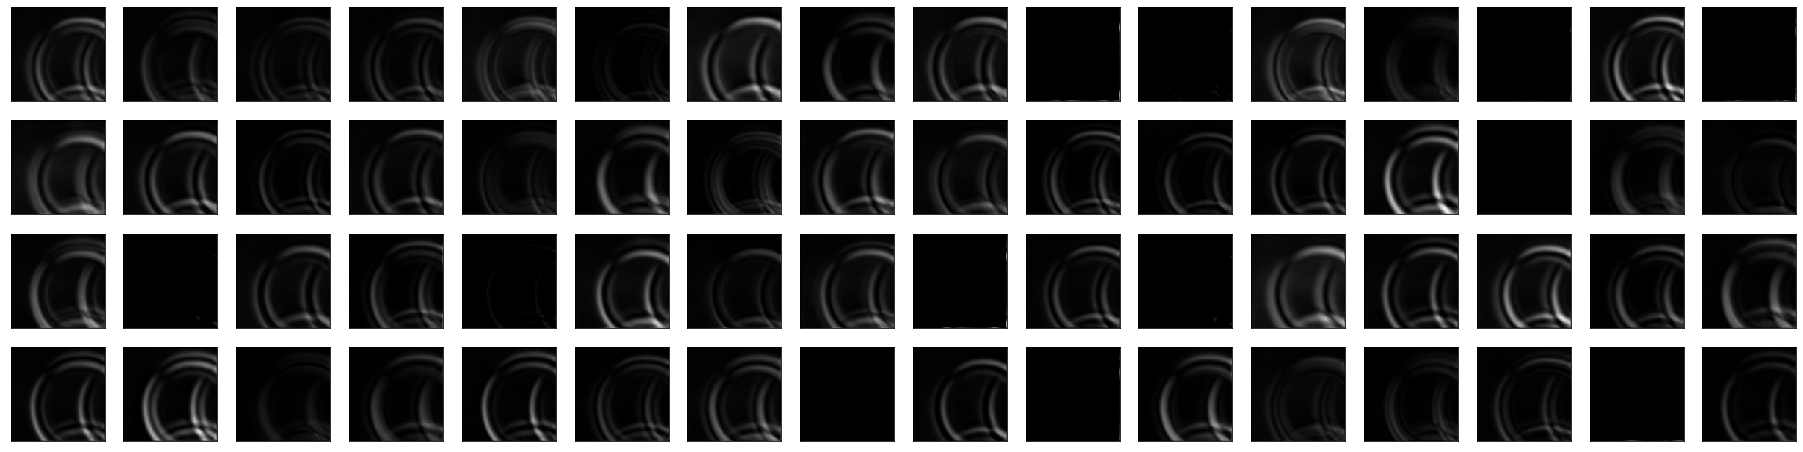

In [163]:
print_activations('dconv_up1.3', index_t=0,  lines=4 , rows=16)

In [164]:
print_activations('conv_last', index_t=0,  lines=2 , rows=10)

torch.Size([20, 128, 128])


In [166]:
def print_cummulative_ouput(frame_number, lines=4, rows=16):
    last = activation['dconv_up1.3'].squeeze()
    w = params['conv_last.weight'].squeeze()
    b = params['conv_last.bias']

    fig, axarr = plt.subplots(lines, rows, figsize=(2*rows, 2*lines))
    img = torch.zeros_like(last[frame_number])
    for i in range(lines):
        for k in range(rows):
            a = i*rows +k
            img += last[a] * w[frame_number, a]
            axarr[i, k].imshow(image_prepro(img + b[frame_number], experiment.normalizer),
                                           cmap='gray', vmin=0, vmax=1)
            axarr[i, k].set_yticks([])
            axarr[i, k].set_xticks([])
    plt.show()

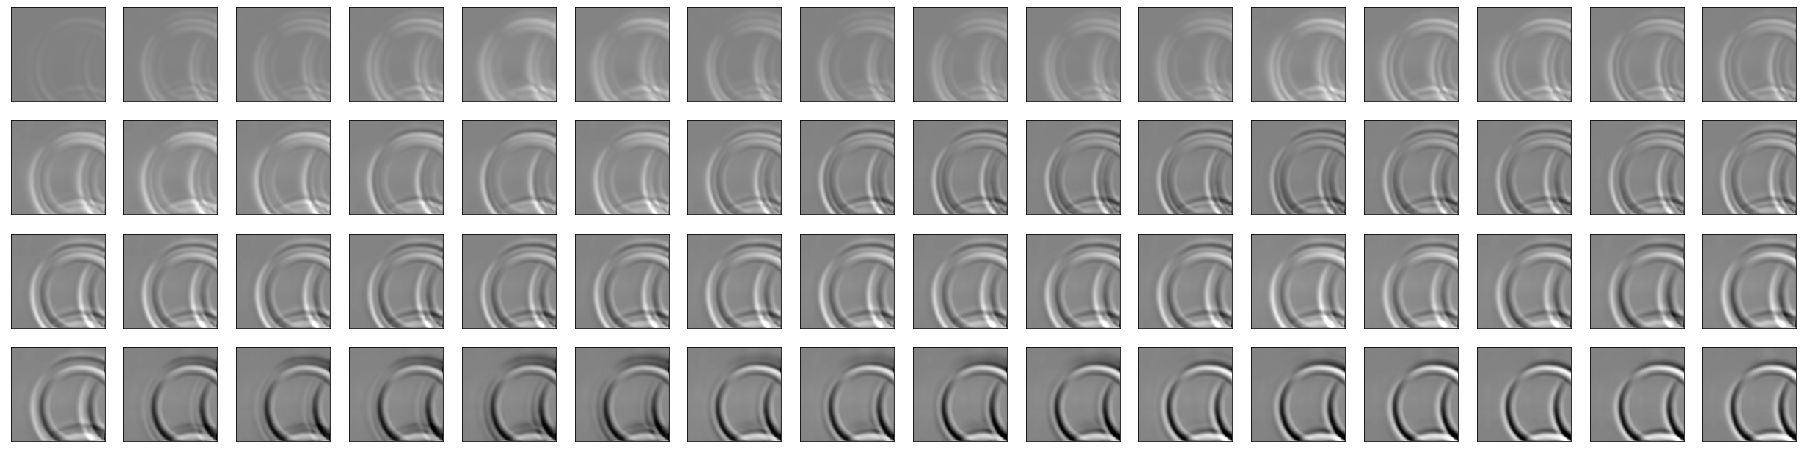

In [167]:
print_cummulative_ouput(frame_number=0, lines=4, rows=16)

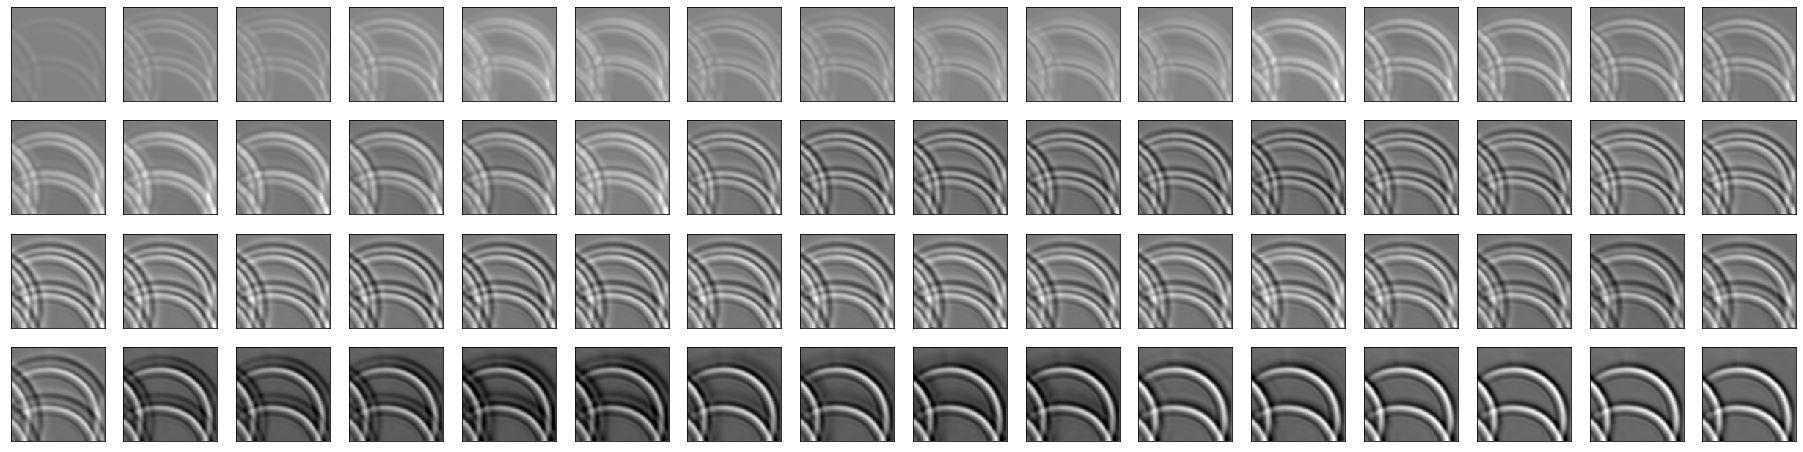

In [119]:
print_cummulative_ouput(frame_number=0, lines=4, rows=16)

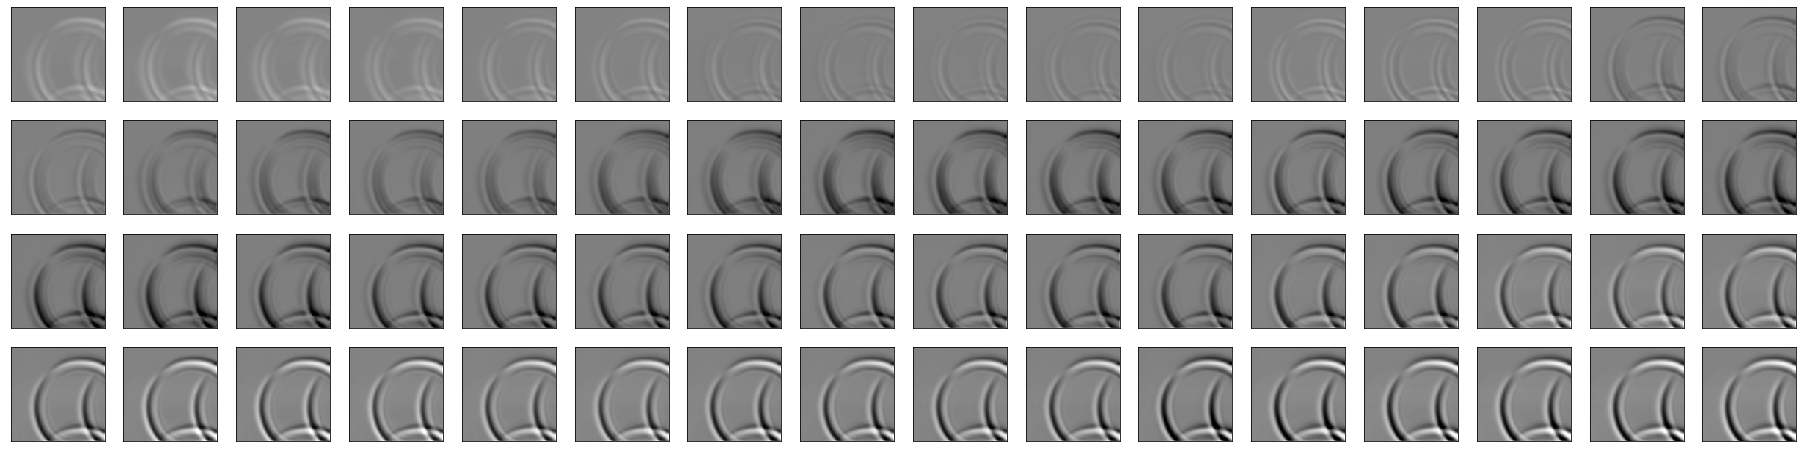

In [168]:
print_cummulative_ouput(frame_number=10, lines=4, rows=16)

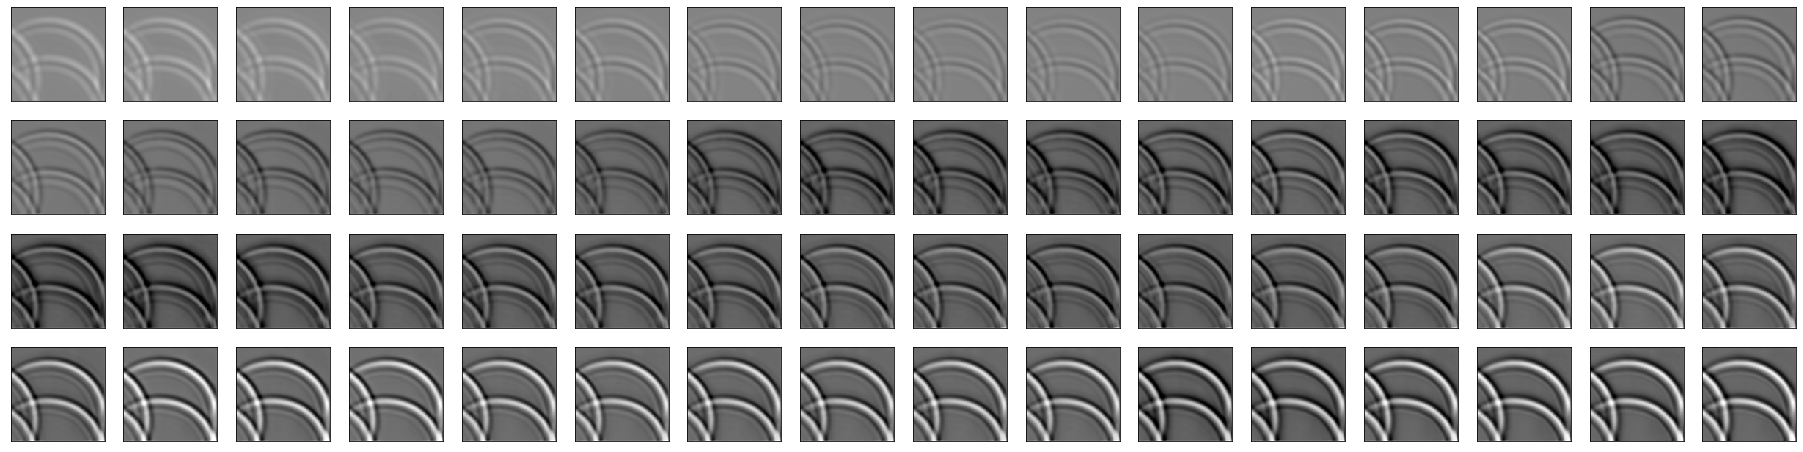

In [120]:
print_cummulative_ouput(frame_number=10, lines=4, rows=16)

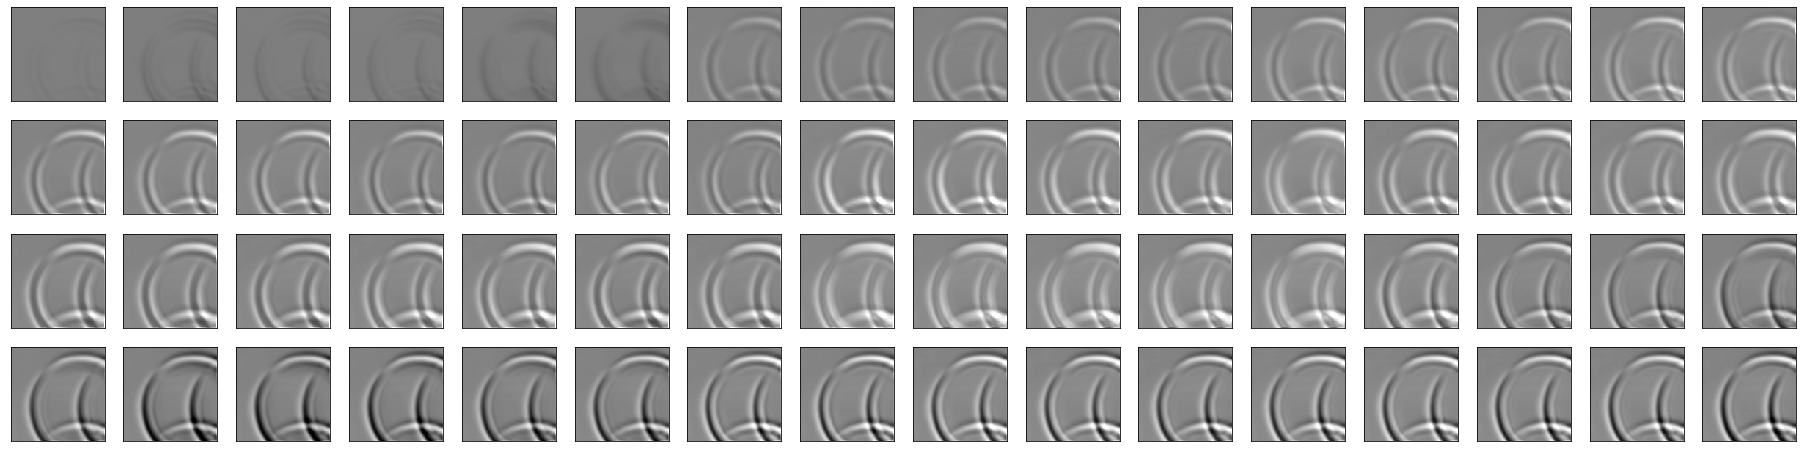

In [169]:
print_cummulative_ouput(frame_number=19, lines=4, rows=16)

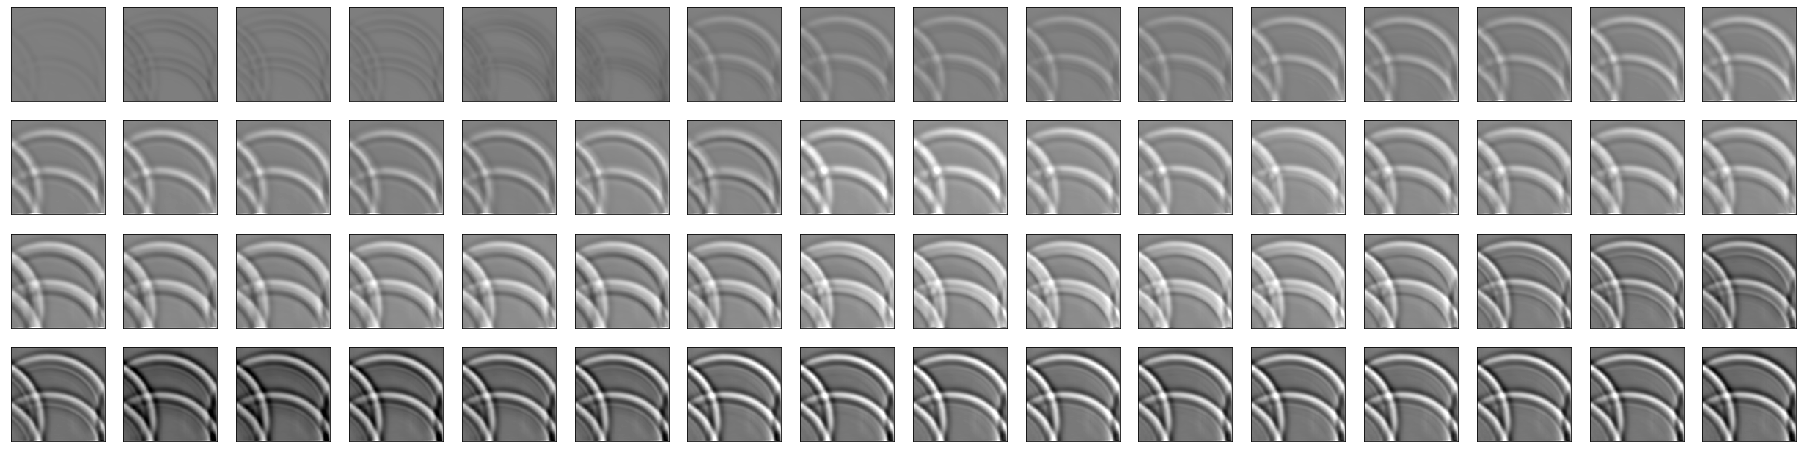

In [121]:
print_cummulative_ouput(frame_number=19, lines=4, rows=16)

In [179]:
w = params['conv_last.weight'].squeeze()
b = params['conv_last.bias']

In [180]:
import plotly.graph_objects as go
import plotly

fig = go.Figure()

for ff in range(w.size(0)):
    fig.add_trace(go.Scatter(
        x=list(range(w.size(0))),
        y=w[ff,:],
       name = 'frame %02d' % ff
    ))

fig.show()